In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---
## VEST's Documentation File


Election Results from South Dakota Secretary of State (https://sdsos.gov/elections-voting/election-resources/election-history/2018_Election_History.aspx)
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release, with the exceptions of Potter County and Yankton County from the 2010 Census VTD release.

Brookings, Brown, Hughes, Hyde, Potter, Sully, and Yankton use countywide vote centers rather than polling locations by precinct. South Dakota counties with vote centers do not record votes by precinct. For these counties, votes were apportioned to precincts based on their share of the countywide number of ballots cast by voters registered with the party of the respective candidates. When this method was tested with counties that report votes by precinct the great majority of precincts were within 4% of the actual candidate vote shares. However, a scattering of precincts deviated by as much as 12% from the actual vote shares. These precincts tend to be in either city centers or outlying areas, which reflects the fact that registered Democrats in rural precincts are more likely to vote for Republican candidates than registered Democrats in urban precincts.

Lawrence County reported absentee votes countywide. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

The certified precinct report from Minnehaha County adds up to about 500 fewer votes per office than the countywide totals recorded in the official state canvass.  This was evidently an oversight in which the preliminary vote count from Minnehaha County was not updated before the final state canvass.

The following modifications were made in the shapefiles to recreate the 2018 precinct boundaries.

Beadle: Replace 5 commissioner districts with 10 precincts \
Bennett: Merge Martin City wards \
Brown: Adjust 12/16, 21/22; revise Aberdeen city limits to 2018 boundary \
Brule: Merge divisions of 3 \
Butte: Merge 8/13/14 \
Charles Mix: Merge divisions of 3, 6, 11, 12  \
Clark: Replace 5 commissioner districts with 13 precincts \
Codington: 3 county VTDs reorganized into 11 precincts by township list; merge Watertown wards A3/A4, B1/B4/E5, B3/C1, C2/D4, C3/C4, E1/E4, E2/E3 \
Corson: Merge McIntosh/South McIntosh, Lincoln/Oak Creek \
Davison: Merge 4/5, 6/7, 8/9, 10/11, 12/13, 14/16, 17/18/19 \
Day: Merge divisions of 2, 5, 6; Revise Webster city boundaries \
Dewey: Merge 3/4, 10/11, 12/13 \
Fall River: Merge Edgemont, Oelrichs \
Faulk: Split 6/7 \
Grant: Split 41/45/53, 43/47, 44/49/52/54; Add Milbank wards \
Hand: Merge 1/3, 4/6, 5/8, 9/10, divisions of 11, 12 \
Hyde: Replace 5 commissioner districts with 3 precincts \
Jackson: Merge divisions of 3, 4 \
Jones: Merge divisions of 1, 3 \
Kingsbury: Replace 5 commissioner districts with 6 precincts \
Lawrence: Merge Whitewood, Rural #1 \
Lincoln: Merge Beresford, Canton 1-3, Canton 4-5, Lennox, Tea \
Mellette: Revise Central/East/West boundaries, White River city limits \
McPherson: Merge Eureka wards with 4/5/6, Leola ward with 1/2 \
Minnehaha: Merge 1-4/1-5, 4-1/4-14, 4-7/4-8, 5-1/5-2; reverse changes to corporate boundary since 2018 \
Pennington: Merge CA/SC, HR/LS/RK \
Perkins: Merge divisions of 3 \
Potter: Adjust Gettysburg ward boundaries; Merge divisions of 26, 27 \
Roberts: Merge 6/7, 12/14 \
Sully: Revise all precinct boundaries to align with county PDF \
Union: Merge divisions of 2, 6 \
Yankton: Revise Yankton city precincts to align with city limits \
Ziebach: Merge Redelm/N&S Dupree

* G18GOVRNOE - Kristi Noem (Republican Party)
* G18GOVDSUT - Billie Sutton (Democratic Party)
* G18GOVLEVA - Kurt Evans (Libertarian Party)


* G18ATGRRAV - Jason Ravnsborg (Republican Party)
* G18ATGDSEI - Randy Seiler (Democratic Party)


* G18SOSRBAR - Steve Barnett (Republican Party)
* G18SOSDFRE - Alexandra Frederick (Democratic Party)


* G18TRERHAE - Josh Haeder (Republican Party)
* G18TREDMAT - Aaron Matson (Democratic Party)


* G18AUDRSAT - Rich Sattgast (Republican Party)
* G18AUDDCOO - Tom Cool (Democratic Party)


* G18PUCRFIE - Kristie Fiegen (Republican Party)
* G18PUCDFRE - Wayne Frederick (Democratic Party)


* G18SPLRBRU - Ryan Brunner (Republican Party)
* G18SPLDHOU - Woody Houser (Democratic Party)


* G18HALRJOH - Dustin "Dusty" Johnson (Republican Party)
* G18HALDBJO - Tim Bjorkman (Democratic Party)
* G18HALLHEN - George D. Hendrickson (Libertarian Party)
* G18HALIWIE - Ron Wieczorek (Independent)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/sd_2018/sd_2018.shp")

In [3]:
vest_shp.shape

(737, 24)

In [4]:
vest_shp.head()

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,geometry
0,46,003,0VTD-1,Precinct 1,165,102,6,177,91,199,...,65,192,69,181,74,180,77,2,11,"POLYGON Z ((-98.44574 43.75991 0.00000, -98.44..."
1,46,003,0VTD-2,Precinct 2,90,54,4,105,40,110,...,38,106,30,101,33,94,46,0,7,"POLYGON Z ((-98.67633 43.49910 0.00000, -98.67..."
2,46,003,0VTD-3,Precinct 3,168,215,9,188,182,219,...,138,217,129,189,144,199,165,2,19,"POLYGON Z ((-98.80777 43.93522 0.00000, -98.80..."
3,46,003,0VTD-5,Precinct 5,78,93,2,83,81,103,...,59,111,53,90,69,90,57,2,18,"POLYGON Z ((-98.57036 43.93450 0.00000, -98.57..."
4,46,003,0VTD-7,Precinct 7,143,143,8,149,127,199,...,100,181,89,173,92,165,98,5,23,"POLYGON Z ((-98.49224 43.72048 0.00000, -98.49..."


<AxesSubplot:>

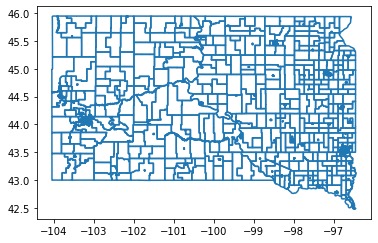

In [5]:
vest_shp.boundary.plot()

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2018 general: https://sdsos.gov/elections-voting/election-resources/election-history/2018_Election_History.aspx

### Governor Election Results

In [6]:
# Import governor election results file
gov_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - GOV.xlsx")
counties = gov_18.sheet_names

# Create empty list to collect dataframes
df_gov = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(gov_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_gov.append(df)
    
# Create the final dataframe    
combined_df_gov = pd.concat(df_gov)

# Rename the columns to match VEST
combined_df_gov.columns = ['County','Precinct','G18GOVLEVA','G18GOVRNOE','G18GOVDSUT']

# Reorder the columns to match VEST
combined_df_gov = combined_df_gov.reindex(columns=['County','Precinct','G18GOVRNOE','G18GOVDSUT','G18GOVLEVA'])

# Remove the rows with column names and rows with total votes
combined_df_gov = combined_df_gov[combined_df_gov["Precinct"]!="Precinct"]
combined_df_gov = combined_df_gov[combined_df_gov["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_gov = combined_df_gov.sort_values(by =['County','Precinct'], ascending = True)

#Fill n/a values with 0
combined_df_gov = combined_df_gov.fillna(0)

# Deal with the index
combined_df_gov.reset_index(drop=True, inplace=True)

combined_df_gov

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA
0,Aurora,Precinct-1,165,102,6
1,Aurora,Precinct-2,90,54,4
2,Aurora,Precinct-3,168,215,9
3,Aurora,Precinct-5,78,93,2
4,Aurora,Precinct-7,143,143,8
...,...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,11,61,3
694,Ziebach,Precinct-3 Davis,45,184,0
695,Ziebach,Precinct-4 Glad Valley,27,34,0
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",144,210,3


### Attorney General Election Results

In [7]:
# Import attorney general election results file
atg_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - ATG.xlsx")
counties = atg_18.sheet_names

# Create empty list to collect dataframes
df_atg = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(atg_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_atg.append(df)
# Create the final dataframe    
combined_df_atg = pd.concat(df_atg)

# Rename the columns to match VEST
combined_df_atg.columns = ['County','Precinct','G18ATGRRAV','G18ATGDSEI']

# Remove the rows with column names and rows with total votes
combined_df_atg = combined_df_atg[combined_df_atg["Precinct"]!="Precinct"]
combined_df_atg = combined_df_atg[combined_df_atg["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_atg = combined_df_atg.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_atg = combined_df_atg.fillna(0)

# Deal with the index
combined_df_atg.reset_index(drop=True,inplace=True)

combined_df_atg

,County,Precinct,G18ATGRRAV,G18ATGDSEI
0,Aurora,Precinct-1,177,91
1,Aurora,Precinct-2,105,40
2,Aurora,Precinct-3,188,182
3,Aurora,Precinct-5,83,81
4,Aurora,Precinct-7,149,127
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,10,61
694,Ziebach,Precinct-3 Davis,49,172
695,Ziebach,Precinct-4 Glad Valley,33,28
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",155,194


### Secretary of State Election Results

In [8]:
# Import secretary of state election results file
sos_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - SOS.xlsx")
counties = sos_18.sheet_names

# Create empty list to collect dataframes
df_sos = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(sos_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_sos.append(df)
# Create the final dataframe    
combined_df_sos = pd.concat(df_sos)

# Rename the columns to match VEST
combined_df_sos.columns = ['County','Precinct','G18SOSRBAR','G18SOSDFRE']

# Remove the rows with column names and rows with total votes
combined_df_sos = combined_df_sos[combined_df_sos["Precinct"]!="Precinct"]
combined_df_sos = combined_df_sos[combined_df_sos["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_sos = combined_df_sos.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_sos = combined_df_sos.fillna(0)

# Deal with the index
combined_df_sos.reset_index(drop=True,inplace=True)

combined_df_sos

,County,Precinct,G18SOSRBAR,G18SOSDFRE
0,Aurora,Precinct-1,199,67
1,Aurora,Precinct-2,110,33
2,Aurora,Precinct-3,219,141
3,Aurora,Precinct-5,103,64
4,Aurora,Precinct-7,199,86
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,8,63
694,Ziebach,Precinct-3 Davis,72,145
695,Ziebach,Precinct-4 Glad Valley,49,12
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",183,153


### State Treasurer Election Results

In [9]:
# Import treasurer election results file
tre_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - TRE.xlsx")
counties = tre_18.sheet_names

# Create empty list to collect dataframes
df_tre = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(tre_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_tre.append(df)
# Create the final dataframe    
combined_df_tre = pd.concat(df_tre)

# Rename the columns to match VEST
combined_df_tre.columns = ['County','Precinct','G18TRERHAE','G18TREDMAT']

# Remove the rows with column names and rows with total votes
combined_df_tre = combined_df_tre[combined_df_tre["Precinct"]!="Precinct"]
combined_df_tre = combined_df_tre[combined_df_tre["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_tre = combined_df_tre.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_tre = combined_df_tre.fillna(0)

# Deal with the index
combined_df_tre.reset_index(drop=True,inplace=True)

combined_df_tre

,County,Precinct,G18TRERHAE,G18TREDMAT
0,Aurora,Precinct-1,184,71
1,Aurora,Precinct-2,100,35
2,Aurora,Precinct-3,189,153
3,Aurora,Precinct-5,86,72
4,Aurora,Precinct-7,157,106
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,14,57
694,Ziebach,Precinct-3 Davis,62,152
695,Ziebach,Precinct-4 Glad Valley,41,17
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",172,162


### State Auditor Election Results

In [10]:
# Import auditor election results file
aud_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - AUD.xlsx")
counties = aud_18.sheet_names

# Create empty list to collect dataframes
df_aud = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(aud_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_aud.append(df)
# Create the final dataframe    
combined_df_aud = pd.concat(df_aud)

# Rename the columns to match VEST
combined_df_aud.columns = ['County','Precinct','G18AUDRSAT','G18AUDDCOO']

# Remove the rows with column names and rows with total votes
combined_df_aud = combined_df_aud[combined_df_aud["Precinct"]!="Precinct"]
combined_df_aud = combined_df_aud[combined_df_aud["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_aud = combined_df_aud.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_aud = combined_df_aud.fillna(0)

# Deal with the index
combined_df_aud.reset_index(drop=True,inplace=True)

combined_df_aud

,County,Precinct,G18AUDRSAT,G18AUDDCOO
0,Aurora,Precinct-1,195,65
1,Aurora,Precinct-2,99,38
2,Aurora,Precinct-3,208,138
3,Aurora,Precinct-5,103,59
4,Aurora,Precinct-7,170,100
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,14,59
694,Ziebach,Precinct-3 Davis,66,150
695,Ziebach,Precinct-4 Glad Valley,43,15
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",183,153


### Public Utilities Commissioner Election Results

In [11]:
# Import PUC election results file
puc_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - PUC.xlsx")
counties = puc_18.sheet_names

# Create empty list to collect dataframes
df_puc = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(puc_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_puc.append(df)
# Create the final dataframe    
combined_df_puc = pd.concat(df_puc)

# Rename the columns to match VEST
combined_df_puc.columns = ['County','Precinct','G18PUCRFIE','G18PUCDFRE']

# Remove the rows with column names and rows with total votes
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="Precinct"]
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_puc = combined_df_puc.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_puc = combined_df_puc.fillna(0)

# Deal with the index
combined_df_puc.reset_index(drop=True,inplace=True)

combined_df_puc

,County,Precinct,G18PUCRFIE,G18PUCDFRE
0,Aurora,Precinct-1,192,69
1,Aurora,Precinct-2,106,30
2,Aurora,Precinct-3,217,129
3,Aurora,Precinct-5,111,53
4,Aurora,Precinct-7,181,89
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,12,59
694,Ziebach,Precinct-3 Davis,68,148
695,Ziebach,Precinct-4 Glad Valley,46,15
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",183,146


### Commissioner of School and Public Lands Election Results

In [12]:
# Import SPL election results file
spl_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - SPL.xlsx")
counties = spl_18.sheet_names

# Create empty list to collect dataframes
df_spl = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(spl_18, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_spl.append(df)
# Create the final dataframe    
combined_df_spl = pd.concat(df_spl)

# Rename the columns to match VEST
combined_df_spl.columns = ['County','Precinct','G18SPLRBRU','G18SPLDHOU']

# Remove the rows with column names and rows with total votes
combined_df_spl = combined_df_spl[combined_df_spl["Precinct"]!="Precinct"]
combined_df_spl = combined_df_spl[combined_df_spl["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_spl = combined_df_spl.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_spl = combined_df_spl.fillna(0)

# Deal with the index
combined_df_spl.reset_index(drop=True,inplace=True)

combined_df_spl

,County,Precinct,G18SPLRBRU,G18SPLDHOU
0,Aurora,Precinct-1,181,74
1,Aurora,Precinct-2,101,33
2,Aurora,Precinct-3,189,144
3,Aurora,Precinct-5,90,69
4,Aurora,Precinct-7,173,92
...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,13,62
694,Ziebach,Precinct-3 Davis,63,150
695,Ziebach,Precinct-4 Glad Valley,40,17
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",178,145


### U.S. Representative

In [13]:
# Import representative election results file
hal_18 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - HAL.xlsx")
counties = hal_18.sheet_names

# Create empty list to collect dataframes
df_hal = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(hal_18, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_hal.append(df)
# Create the final dataframe    
combined_df_hal = pd.concat(df_hal)

# Rename the columns to match VEST
combined_df_hal.columns = ['County','Precinct','G18HALLHEN','G18HALRJOH','G18HALDBJO','G18HALIWIE']

# Reorder the columns to match VEST
combined_df_hal = combined_df_hal.reindex(columns=['County','Precinct','G18HALRJOH','G18HALDBJO','G18HALLHEN','G18HALIWIE'])

# Remove the rows with column names and rows with total votes
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="Precinct"]
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="TOTALS"]

# Display results in alphabetical order of the counties and precincts
combined_df_hal = combined_df_hal.sort_values(by =['County','Precinct'], ascending = True)

# Fill n/a values with 0
combined_df_hal = combined_df_hal.fillna(0)

# Deal with the index
combined_df_hal.reset_index(drop=True,inplace=True)

combined_df_hal

,County,Precinct,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE
0,Aurora,Precinct-1,180,77,2,11
1,Aurora,Precinct-2,94,46,0,7
2,Aurora,Precinct-3,199,165,2,19
3,Aurora,Precinct-5,90,57,2,18
4,Aurora,Precinct-7,165,98,5,23
...,...,...,...,...,...,...
693,Ziebach,Precinct-2 Cherry Creek,14,50,2,4
694,Ziebach,Precinct-3 Davis,65,145,6,5
695,Ziebach,Precinct-4 Glad Valley,47,12,1,1
696,Ziebach,"Precinct-5 North Dupree (Precinct-6 Redelm, Pr...",187,145,4,13


### Combine Results

In [14]:
# Concatenate all dataframes
sd_18 = pd.concat([combined_df_gov,combined_df_atg,combined_df_sos,combined_df_tre,combined_df_aud,combined_df_puc,combined_df_spl,combined_df_hal],axis=1)

# Drop repeated column (County)
sd_18 = sd_18.loc[:,~sd_18.columns.duplicated()]

# Make sure the number of votes are recorded in the form of integers (Change if not - County and Precinct columns remain unchanged)
sd_18 = sd_18.apply(pd.to_numeric, errors='ignore')

# Make sure the county names and precinct names are in string form
sd_18['County'] = sd_18['County'].astype(str)
sd_18['Precinct'] = sd_18['Precinct'].astype(str)

sd_18.head()

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDRSAT,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE
0,Aurora,Precinct-1,165,102,6,177,91,199,67,184,...,195,65,192,69,181,74,180,77,2,11
1,Aurora,Precinct-2,90,54,4,105,40,110,33,100,...,99,38,106,30,101,33,94,46,0,7
2,Aurora,Precinct-3,168,215,9,188,182,219,141,189,...,208,138,217,129,189,144,199,165,2,19
3,Aurora,Precinct-5,78,93,2,83,81,103,64,86,...,103,59,111,53,90,69,90,57,2,18
4,Aurora,Precinct-7,143,143,8,149,127,199,86,157,...,170,100,181,89,173,92,165,98,5,23


### Add in FIPS File
Note: Oglala Lakota county was originally named Shannon county - the county was renamed in 2015.

In [15]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Dakota"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
sd_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
sd_fips_dict_alt = {v: k for k, v in sd_fips_dict.items()}


# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"Oglala Lakota":"Shannon"}
sd_18["County"] = sd_18["County"].map(county_name_changes_dict).fillna(sd_18["County"])

In [16]:
sd_fips_dict

{'AURORA': '003',
 'BEADLE': '005',
 'BENNETT': '007',
 'BON HOMME': '009',
 'BROOKINGS': '011',
 'BROWN': '013',
 'BRULE': '015',
 'BUFFALO': '017',
 'BUTTE': '019',
 'CAMPBELL': '021',
 'CHARLES MIX': '023',
 'CLARK': '025',
 'CLAY': '027',
 'CODINGTON': '029',
 'CORSON': '031',
 'CUSTER': '033',
 'DAVISON': '035',
 'DAY': '037',
 'DEUEL': '039',
 'DEWEY': '041',
 'DOUGLAS': '043',
 'EDMUNDS': '045',
 'FALL RIVER': '047',
 'FAULK': '049',
 'GRANT': '051',
 'GREGORY': '053',
 'HAAKON': '055',
 'HAMLIN': '057',
 'HAND': '059',
 'HANSON': '061',
 'HARDING': '063',
 'HUGHES': '065',
 'HUTCHINSON': '067',
 'HYDE': '069',
 'JACKSON': '071',
 'JERAULD': '073',
 'JONES': '075',
 'KINGSBURY': '077',
 'LAKE': '079',
 'LAWRENCE': '081',
 'LINCOLN': '083',
 'LYMAN': '085',
 'MCCOOK': '087',
 'MCPHERSON': '089',
 'MARSHALL': '091',
 'MEADE': '093',
 'MELLETTE': '095',
 'MINER': '097',
 'MINNEHAHA': '099',
 'MOODY': '101',
 'PENNINGTON': '103',
 'PERKINS': '105',
 'POTTER': '107',
 'ROBERTS': '109

In [17]:
sd_18["County"].unique()

array(['Aurora', 'Beadle', 'Bennett', 'Bon Homme', 'Brookings', 'Brown',
       'Brule', 'Buffalo', 'Butte', 'Campbell', 'Charles Mix', 'Clark',
       'Clay', 'Codington', 'Corson', 'Custer', 'Davison', 'Day', 'Deuel',
       'Dewey', 'Douglas', 'Edmunds', 'Fall River', 'Faulk', 'Grant',
       'Gregory', 'Haakon', 'Hamlin', 'Hand', 'Hanson', 'Harding',
       'Hughes', 'Hutchinson', 'Hyde', 'Jackson', 'Jerauld', 'Jones',
       'Kingsbury', 'Lake', 'Lawrence', 'Lincoln', 'Lyman', 'Marshall',
       'McCook', 'McPherson', 'Meade', 'Mellette', 'Miner', 'Minnehaha',
       'Moody', 'Shannon', 'Pennington', 'Perkins', 'Potter', 'Roberts',
       'Sanborn', 'Spink', 'Stanley', 'Sully', 'Todd', 'Tripp', 'Turner',
       'Union', 'Walworth', 'Yankton', 'Ziebach'], dtype=object)

In [18]:
county_dict = {'Aurora':'AURORA', 'Beadle':'BEADLE', 'Bennett':'BENNETT', 'Bon Homme':'BON HOMME', 'Brookings':'BROOKINGS', 'Brown':'BROWN',
       'Brule':'BRULE', 'Buffalo':'BUFFALO', 'Butte':'BUTTE', 'Campbell':'CAMPBELL', 'Charles Mix':'CHARLES MIX', 'Clark':'CLARK',
       'Clay':'CLAY', 'Codington':'CODINGTON', 'Corson':'CORSON', 'Custer':'CUSTER', 'Davison':'DAVISON', 'Day':'DAY', 'Deuel':'DEUEL',
       'Dewey':'DEWEY', 'Douglas':'DOUGLAS', 'Edmunds':'EDMUNDS', 'Fall River':'FALL RIVER', 'Faulk':'FAULK', 'Grant':'GRANT',
       'Gregory':'GREGORY', 'Haakon':'HAAKON', 'Hamlin':'HAMLIN', 'Hand':'HAND', 'Hanson':'HANSON', 'Harding':'HARDING',
       'Hughes':'HUGHES', 'Hutchinson':'HUTCHINSON', 'Hyde':'HYDE', 'Jackson':'JACKSON', 'Jerauld':'JERAULD', 'Jones':'JONES',
       'Kingsbury':'KINGSBURY', 'Lake':'LAKE', 'Lawrence':'LAWRENCE', 'Lincoln':'LINCOLN', 'Lyman':'LYMAN', 'Marshall':'MARSHALL',
       'McCook':'MCCOOK', 'McPherson':'MCPHERSON', 'Meade':'MEADE', 'Mellette':'MELLETTE', 'Miner':'MINER', 'Minnehaha':'MINNEHAHA',
       'Moody':'MOODY', 'Shannon':'SHANNON', 'Pennington':'PENNINGTON', 'Perkins':'PERKINS', 'Potter':'POTTER', 'Roberts':'ROBERTS',
       'Sanborn':'SANBORN', 'Spink':'SPINK', 'Stanley':'STANLEY', 'Sully':'SULLY', 'Todd':'TODD', 'Tripp':'TRIPP', 'Turner':'TURNER',
       'Union':'UNION', 'Walworth':'WALWORTH', 'Yankton':'YANKTON', 'Ziebach':'ZIEBACH'
}

In [19]:
# Use the dictionary to change the names
sd_18["County"]=sd_18["County"].map(county_dict).fillna(sd_18["County"])

In [20]:
# Map to the correct FIPS
sd_18["COUNTYFP"]=sd_18["County"].map(sd_fips_dict).fillna(sd_18["County"])

# Print out the FIPS to make sure they all are in the correct format
sd_18["County"].unique()

array(['AURORA', 'BEADLE', 'BENNETT', 'BON HOMME', 'BROOKINGS', 'BROWN',
       'BRULE', 'BUFFALO', 'BUTTE', 'CAMPBELL', 'CHARLES MIX', 'CLARK',
       'CLAY', 'CODINGTON', 'CORSON', 'CUSTER', 'DAVISON', 'DAY', 'DEUEL',
       'DEWEY', 'DOUGLAS', 'EDMUNDS', 'FALL RIVER', 'FAULK', 'GRANT',
       'GREGORY', 'HAAKON', 'HAMLIN', 'HAND', 'HANSON', 'HARDING',
       'HUGHES', 'HUTCHINSON', 'HYDE', 'JACKSON', 'JERAULD', 'JONES',
       'KINGSBURY', 'LAKE', 'LAWRENCE', 'LINCOLN', 'LYMAN', 'MARSHALL',
       'MCCOOK', 'MCPHERSON', 'MEADE', 'MELLETTE', 'MINER', 'MINNEHAHA',
       'MOODY', 'SHANNON', 'PENNINGTON', 'PERKINS', 'POTTER', 'ROBERTS',
       'SANBORN', 'SPINK', 'STANLEY', 'SULLY', 'TODD', 'TRIPP', 'TURNER',
       'UNION', 'WALWORTH', 'YANKTON', 'ZIEBACH'], dtype=object)

In [21]:
sd_18.head(1)

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,AURORA,Precinct-1,165,102,6,177,91,199,67,184,...,65,192,69,181,74,180,77,2,11,003


In [22]:
inv_sd_fips_dict = {v: k for k, v in sd_fips_dict.items()}
vest_shp["County_Name"]=vest_shp["COUNTYFP"].map(inv_sd_fips_dict).fillna(vest_shp["COUNTYFP"])
vest_shp

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,...,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,geometry,County_Name
0,46,003,0VTD-1,Precinct 1,165,102,6,177,91,199,...,192,69,181,74,180,77,2,11,"POLYGON Z ((-98.44574 43.75991 0.00000, -98.44...",AURORA
1,46,003,0VTD-2,Precinct 2,90,54,4,105,40,110,...,106,30,101,33,94,46,0,7,"POLYGON Z ((-98.67633 43.49910 0.00000, -98.67...",AURORA
2,46,003,0VTD-3,Precinct 3,168,215,9,188,182,219,...,217,129,189,144,199,165,2,19,"POLYGON Z ((-98.80777 43.93522 0.00000, -98.80...",AURORA
3,46,003,0VTD-5,Precinct 5,78,93,2,83,81,103,...,111,53,90,69,90,57,2,18,"POLYGON Z ((-98.57036 43.93450 0.00000, -98.57...",AURORA
4,46,003,0VTD-7,Precinct 7,143,143,8,149,127,199,...,181,89,173,92,165,98,5,23,"POLYGON Z ((-98.49224 43.72048 0.00000, -98.49...",AURORA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,46,135,VTD-5,Precinct 5 YanktonCity,1007,950,28,1202,737,1289,...,1242,602,1147,668,1268,675,22,43,"POLYGON Z ((-97.41707 42.90295 0.00000, -97.41...",YANKTON
733,46,135,VTD-26,Precinct 26,740,680,23,883,528,947,...,912,431,843,478,932,483,18,35,"MULTIPOLYGON Z (((-97.42216 42.87983 0.00000, ...",YANKTON
734,46,135,VTD-23,Precinct 23 MissionHillTwp,107,81,3,128,63,137,...,132,52,122,57,135,58,2,5,"POLYGON Z ((-97.39870 42.99594 0.00000, -97.39...",YANKTON
735,46,135,VTD-28,Precinct 28,122,153,3,146,119,156,...,150,97,139,108,153,109,3,5,"MULTIPOLYGON Z (((-97.37734 42.90526 0.00000, ...",YANKTON


In [23]:
# Check the number of counties - looking for 66
print(len(sd_18["COUNTYFP"].unique()))

66


In [24]:
sd_18.to_csv("./sd18.csv")

### Compare Vote Totals Before Allocation

In [25]:
races = [x for x in vest_shp.columns if 'G18' in x]
races

['G18GOVRNOE',
 'G18GOVDSUT',
 'G18GOVLEVA',
 'G18ATGRRAV',
 'G18ATGDSEI',
 'G18SOSRBAR',
 'G18SOSDFRE',
 'G18TRERHAE',
 'G18TREDMAT',
 'G18AUDRSAT',
 'G18AUDDCOO',
 'G18PUCRFIE',
 'G18PUCDFRE',
 'G18SPLRBRU',
 'G18SPLDHOU',
 'G18HALRJOH',
 'G18HALDBJO',
 'G18HALLHEN',
 'G18HALIWIE']

In [26]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_18[i])
print(sum_var_1)
print(sum_var_2)

2573997
2573997


## Assign and Reallocate Absentee Votes
Absentee votes reported for Brookings, Brown, Hughes, Lawrence, Potter, Sully, and Yankton counties.

In [27]:
data_columns = ['G18GOVRNOE',
 'G18GOVDSUT',
 'G18GOVLEVA',
 'G18ATGRRAV',
 'G18ATGDSEI',
 'G18SOSRBAR',
 'G18SOSDFRE',
 'G18TRERHAE',
 'G18TREDMAT',
 'G18AUDRSAT',
 'G18AUDDCOO',
 'G18PUCRFIE',
 'G18PUCDFRE',
 'G18SPLRBRU',
 'G18SPLDHOU',
 'G18HALRJOH',
 'G18HALDBJO',
 'G18HALLHEN',
 'G18HALIWIE']

In [28]:
def assign_absentee(filtered_election):
    to_dole_out = filtered_election[filtered_election['Precinct'].str.contains('Absentee')]
    to_dole_out_totals = to_dole_out
    filtered_election = filtered_election[~filtered_election['Precinct'].str.startswith('Absentee')]
    #Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
    precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
    precinct_specific_totals.reset_index(inplace=True,drop=False)
    filtered_election.reset_index(inplace=True,drop=True)
    
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        filtered_election.loc[:,add_var]=0.0
        filtered_election.loc[:,rem_var]=0.0
        filtered_election.loc[:,floor_var]=0.0
    
    for index, row in filtered_election.iterrows():
        #No countywide votes for 510
        if row["County"] in to_dole_out['County'].unique():
            for race in races:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the county
                county_id = row["County"]
                #Get the denominator for the allocation (the precinct vote totals)
                denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
                #Get one of the numerators, how many countywide votes to allocate
                numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]

                #Get the vote totals for this race in this precinct
                val = filtered_election.loc[index,race]

                #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
                if float(denom) !=0:
                    vote_share = (float(val)/float(denom))*float(numer)
                else:
                    vote_share = 0


                filtered_election.loc[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                filtered_election.loc[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                filtered_election.loc[index,floor_var] = np.floor(vote_share)
                
    #After the first pass through, get the sums of the races by county            
    first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

    #Now we want to iterate county by county to work on rounding
    county_list = list(to_dole_out_totals["County"].unique()) 

    #Iterate over the counties
    for county in county_list:
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
                filtered_election.loc[index,add_var] = np.ceil(filtered_election.loc[index,add_var])

    #Iterate over every race again
    for race in races:
        add_var = race+"_add"
        #Round every allocation down
        filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
        #Add every allocation to the total
        filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]


    #Filter back down to the original columns
    filtered_election = filtered_election[list(sd_18.columns)]
    return filtered_election

#### Brookings

In [29]:
brookings = sd_18[sd_18["County"]=="BROOKINGS"]

In [30]:
brookings_dict = brookings.to_dict(orient='list')
print(brookings_dict)

{'County': ['BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS', 'BROOKINGS'], 'Precinct': ['1-1 Brookings Activity Center', '1-10 Volga Community Center', '1-11 Holy Life Tabernacle', '1-2 Bethel Baptist Church', '1-3 Swiftel Center', '1-4 Aurora Little Hall', '1-5 Elkton Community Center', '1-6 McKnight Hall', '1-7 Bruce City Hall', '1-8 Trinity Lutheran Church', '1-9 Sinai American Legion', 'Absentee Precinct'], 'G18GOVRNOE': [537, 467, 374, 959, 211, 227, 210, 276, 199, 70, 100, 1595], 'G18GOVDSUT': [968, 422, 447, 1109, 268, 235, 125, 185, 150, 50, 58, 2355], 'G18GOVLEVA': [25, 24, 13, 37, 13, 11, 3, 7, 5, 3, 4, 38], 'G18ATGRRAV': [583, 532, 422, 1010, 224, 256, 198, 296, 222, 68, 106, 1781], 'G18ATGDSEI': [859, 329, 360, 971, 238, 204, 123, 146, 120, 46, 49, 2076], 'G18SOSRBAR': [714, 622, 480, 1256, 285, 289, 246, 333, 253, 71, 126, 2069], 'G18SOSDFRE': [730, 240, 291, 727, 177, 160, 76, 11

In [31]:
brookings_df = pd.DataFrame(brookings_dict)
brookings_df = assign_absentee(brookings_df)
brookings_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,BROOKINGS,1-1 Brookings Activity Center,773.0,1536.0,32.0,848.0,1377.0,1030.0,1223.0,970.0,...,1161.0,1097.0,1084.0,1065.0,1115.0,971.0,1250.0,47.0,64.0,011
1,BROOKINGS,1-10 Volga Community Center,672.0,669.0,30.0,774.0,527.0,897.0,402.0,763.0,...,414.0,906.0,369.0,850.0,371.0,815.0,476.0,25.0,40.0,011
2,BROOKINGS,1-11 Holy Life Tabernacle,538.0,709.0,16.0,614.0,577.0,693.0,488.0,646.0,...,471.0,727.0,446.0,695.0,452.0,703.0,505.0,22.0,24.0,011
3,BROOKINGS,1-2 Bethel Baptist Church,1380.0,1759.0,47.0,1469.0,1556.0,1812.0,1218.0,1647.0,...,1256.0,1809.0,1152.0,1782.0,1180.0,1708.0,1315.0,45.0,78.0,011
4,BROOKINGS,1-3 Swiftel Center,304.0,425.0,16.0,326.0,381.0,411.0,297.0,379.0,...,306.0,418.0,261.0,408.0,269.0,390.0,307.0,13.0,18.0,011
5,BROOKINGS,1-4 Aurora Little Hall,327.0,373.0,14.0,372.0,327.0,417.0,268.0,387.0,...,259.0,420.0,246.0,395.0,266.0,393.0,272.0,12.0,38.0,011
6,BROOKINGS,1-5 Elkton Community Center,302.0,198.0,4.0,288.0,197.0,355.0,127.0,331.0,...,125.0,348.0,125.0,333.0,136.0,348.0,122.0,6.0,17.0,011
7,BROOKINGS,1-6 McKnight Hall,397.0,294.0,9.0,431.0,234.0,480.0,184.0,434.0,...,185.0,476.0,183.0,433.0,201.0,468.0,200.0,9.0,14.0,011
8,BROOKINGS,1-7 Bruce City Hall,287.0,238.0,6.0,323.0,192.0,365.0,143.0,339.0,...,150.0,359.0,149.0,337.0,150.0,344.0,146.0,10.0,18.0,011
9,BROOKINGS,1-8 Trinity Lutheran Church,101.0,79.0,4.0,99.0,74.0,102.0,69.0,101.0,...,62.0,109.0,59.0,99.0,65.0,109.0,62.0,4.0,3.0,011


#### Brown

In [32]:
brown = sd_18[sd_18["County"]=="BROWN"]

In [33]:
brown_dict = brown.to_dict(orient='list')
print(brown_dict)

{'County': ['BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN', 'BROWN'], 'Precinct': ['Absentee ', 'AmericInn Event Center', 'Best Western Ramkota Hotel and Convention Center', 'Claremont Fire Station', 'Columbia American Legion', 'Courthouse Community Room', 'Express Vote', 'Frederick Community Center', 'Groton Community Center', 'Hecla Community Center', 'Stratford Communty Center', 'Warner Community Center', 'Westport Community Center'], 'G18GOVRNOE': [1490, 1157, 1081, 59, 87, 949, 1108, 101, 348, 76, 51, 219, 95], 'G18GOVDSUT': [1812, 1166, 896, 58, 103, 1024, 1344, 101, 360, 84, 84, 213, 93], 'G18GOVLEVA': [41, 29, 27, 0, 5, 47, 31, 0, 12, 1, 5, 5, 3], 'G18ATGRRAV': [1586, 1210, 1116, 60, 103, 967, 1241, 119, 347, 77, 59, 198, 103], 'G18ATGDSEI': [1646, 1025, 804, 54, 84, 961, 1199, 79, 315, 77, 66, 218, 81], 'G18SOSRBAR': [2047, 1604, 1499, 69, 129, 1346, 1612, 131, 472, 93, 85, 287, 129], 'G18SOSDFRE': [1222, 657, 465, 45

In [34]:
brown_df = pd.DataFrame(brown_dict)
brown_df = assign_absentee(brown_df)
brown_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,BROWN,AmericInn Event Center,1481.0,1548.0,36.0,1553.0,1365.0,2044.0,904.0,1655.0,...,1078.0,1772.0,1054.0,1638.0,1131.0,1777.0,1156.0,36.0,64.0,013
1,BROWN,Best Western Ramkota Hotel and Convention Center,1383.0,1190.0,34.0,1432.0,1071.0,1911.0,640.0,1574.0,...,773.0,1621.0,796.0,1532.0,830.0,1667.0,817.0,38.0,42.0,013
2,BROWN,Claremont Fire Station,76.0,77.0,0.0,77.0,72.0,88.0,62.0,70.0,...,66.0,86.0,63.0,73.0,73.0,81.0,71.0,0.0,0.0,013
3,BROWN,Columbia American Legion,111.0,137.0,6.0,132.0,112.0,164.0,76.0,127.0,...,89.0,138.0,88.0,131.0,88.0,140.0,105.0,4.0,2.0,013
4,BROWN,Courthouse Community Room,1214.0,1360.0,59.0,1241.0,1280.0,1716.0,849.0,1441.0,...,986.0,1463.0,985.0,1351.0,1025.0,1484.0,1027.0,45.0,59.0,013
5,BROWN,Express Vote,1418.0,1785.0,39.0,1592.0,1597.0,2055.0,1164.0,1794.0,...,1326.0,1890.0,1287.0,1757.0,1384.0,1822.0,1359.0,19.0,47.0,013
6,BROWN,Frederick Community Center,129.0,134.0,0.0,153.0,105.0,167.0,91.0,151.0,...,100.0,154.0,93.0,152.0,97.0,154.0,94.0,4.0,5.0,013
7,BROWN,Groton Community Center,445.0,478.0,15.0,445.0,419.0,602.0,284.0,464.0,...,329.0,547.0,296.0,496.0,327.0,545.0,366.0,6.0,11.0,013
8,BROWN,Hecla Community Center,97.0,112.0,1.0,99.0,102.0,118.0,84.0,98.0,...,87.0,104.0,88.0,89.0,87.0,114.0,89.0,0.0,5.0,013
9,BROWN,Stratford Communty Center,65.0,111.0,6.0,76.0,88.0,108.0,62.0,70.0,...,67.0,77.0,73.0,74.0,67.0,84.0,82.0,0.0,6.0,013


#### Hughes

In [35]:
hughes = sd_18[sd_18["County"]=="HUGHES"]

In [36]:
hughes_dict = hughes.to_dict(orient='list')
print(hughes_dict)

{'County': ['HUGHES', 'HUGHES', 'HUGHES', 'HUGHES', 'HUGHES', 'HUGHES', 'HUGHES', 'HUGHES'], 'Precinct': ['Absentee Precinct', 'Blunt City Hall', 'Faith Lutheran Church', 'Harrold City Auditorium', 'Hyde Residence', 'Lutheran Memorial Church', 'New Life Assembly of God Church', 'PILC Rec Center'], 'G18GOVRNOE': [820, 116, 883, 76, 33, 539, 967, 315], 'G18GOVDSUT': [1015, 63, 1003, 20, 51, 764, 839, 389], 'G18GOVLEVA': [12, 5, 36, 0, 1, 18, 29, 13], 'G18ATGRRAV': [819, 115, 818, 63, 37, 477, 881, 307], 'G18ATGDSEI': [994, 62, 1060, 28, 46, 809, 912, 393], 'G18SOSRBAR': [1239, 138, 1477, 80, 46, 947, 1431, 502], 'G18SOSDFRE': [565, 37, 408, 14, 38, 342, 362, 197], 'G18TRERHAE': [1098, 132, 1313, 73, 39, 849, 1271, 446], 'G18TREDMAT': [628, 41, 479, 15, 39, 389, 450, 234], 'G18AUDRSAT': [1224, 138, 1422, 80, 39, 923, 1380, 506], 'G18AUDDCOO': [558, 38, 422, 14, 41, 351, 381, 194], 'G18PUCRFIE': [1154, 128, 1353, 74, 41, 887, 1324, 472], 'G18PUCDFRE': [573, 42, 444, 15, 39, 356, 404, 217],

In [37]:
hughes_df = pd.DataFrame(hughes_dict)
hughes_df = assign_absentee(hughes_df)
hughes_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,HUGHES,Blunt City Hall,149.0,83.0,6.0,150.0,81.0,175.0,52.0,167.0,...,53.0,163.0,58.0,165.0,58.0,164.0,66.0,1.0,6.0,065
1,HUGHES,Faith Lutheran Church,1130.0,1328.0,40.0,1066.0,1378.0,1873.0,573.0,1663.0,...,585.0,1718.0,612.0,1707.0,611.0,1675.0,724.0,41.0,50.0,065
2,HUGHES,Harrold City Auditorium,97.0,27.0,0.0,82.0,36.0,101.0,20.0,92.0,...,19.0,94.0,21.0,95.0,18.0,95.0,15.0,1.0,7.0,065
3,HUGHES,Hyde Residence,42.0,68.0,1.0,48.0,60.0,58.0,53.0,49.0,...,57.0,52.0,54.0,50.0,54.0,52.0,59.0,0.0,0.0,065
4,HUGHES,Lutheran Memorial Church,690.0,1012.0,20.0,622.0,1052.0,1201.0,480.0,1075.0,...,487.0,1126.0,490.0,1109.0,507.0,1101.0,561.0,13.0,39.0,065
5,HUGHES,New Life Assembly of God Church,1238.0,1111.0,32.0,1149.0,1186.0,1815.0,508.0,1610.0,...,529.0,1681.0,556.0,1608.0,599.0,1700.0,593.0,23.0,42.0,065
6,HUGHES,PILC Rec Center,403.0,515.0,15.0,400.0,511.0,637.0,277.0,565.0,...,269.0,599.0,299.0,570.0,311.0,579.0,314.0,6.0,31.0,065


#### Lawrence

In [38]:
lawrence = sd_18[sd_18["County"]=="LAWRENCE"]

In [39]:
lawrence_dict = lawrence.to_dict(orient='list')
print(lawrence_dict)

{'County': ['LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE', 'LAWRENCE'], 'Precinct': ['Absentee Precinct', 'Precinct-01', 'Precinct-02', 'Precinct-03', 'Precinct-04', 'Precinct-05', 'Precinct-06', 'Precinct-07', 'Precinct-08', 'Precinct-09', 'Precinct-10'], 'G18GOVRNOE': [2323, 381, 509, 602, 331, 129, 101, 254, 82, 395, 877], 'G18GOVDSUT': [1958, 414, 372, 476, 336, 168, 61, 184, 56, 179, 471], 'G18GOVLEVA': [66, 16, 21, 22, 35, 14, 7, 10, 7, 14, 27], 'G18ATGRRAV': [2407, 399, 521, 634, 375, 142, 105, 267, 104, 407, 899], 'G18ATGDSEI': [1824, 372, 341, 424, 303, 164, 59, 164, 37, 168, 419], 'G18SOSRBAR': [2695, 465, 591, 709, 416, 173, 102, 291, 111, 440, 999], 'G18SOSDFRE': [1543, 301, 277, 356, 255, 125, 60, 142, 29, 131, 333], 'G18TRERHAE': [2601, 461, 573, 688, 384, 171, 106, 281, 104, 437, 960], 'G18TREDMAT': [1571, 287, 272, 340, 268, 122, 58, 143, 33, 127, 333], 'G18AUDRSAT': [2682, 482, 582, 712, 413, 180,

In [40]:
lawrence_df = pd.DataFrame(lawrence_dict)
lawrence_df = assign_absentee(lawrence_df)
lawrence_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,LAWRENCE,Precinct-01,623.0,712.0,22.0,648.0,649.0,757.0,532.0,749.0,...,488.0,742.0,503.0,730.0,521.0,753.0,534.0,32.0,35.0,081
1,LAWRENCE,Precinct-02,832.0,640.0,29.0,846.0,595.0,962.0,490.0,931.0,...,497.0,937.0,496.0,921.0,488.0,946.0,485.0,30.0,33.0,081
2,LAWRENCE,Precinct-03,984.0,819.0,31.0,1030.0,739.0,1154.0,629.0,1118.0,...,580.0,1113.0,609.0,1123.0,621.0,1143.0,618.0,30.0,39.0,081
3,LAWRENCE,Precinct-04,541.0,578.0,48.0,609.0,528.0,677.0,451.0,624.0,...,442.0,640.0,438.0,626.0,461.0,652.0,448.0,23.0,39.0,081
4,LAWRENCE,Precinct-05,211.0,289.0,19.0,231.0,286.0,281.0,221.0,278.0,...,208.0,279.0,222.0,271.0,227.0,265.0,216.0,16.0,21.0,081
5,LAWRENCE,Precinct-06,165.0,105.0,10.0,171.0,103.0,166.0,106.0,172.0,...,101.0,173.0,96.0,168.0,101.0,159.0,92.0,8.0,19.0,081
6,LAWRENCE,Precinct-07,415.0,317.0,14.0,434.0,286.0,473.0,251.0,456.0,...,235.0,467.0,240.0,458.0,247.0,467.0,247.0,12.0,23.0,081
7,LAWRENCE,Precinct-08,134.0,96.0,10.0,169.0,65.0,181.0,51.0,169.0,...,50.0,177.0,52.0,189.0,48.0,177.0,51.0,8.0,0.0,081
8,LAWRENCE,Precinct-09,646.0,308.0,19.0,661.0,293.0,716.0,232.0,710.0,...,217.0,716.0,216.0,719.0,216.0,708.0,207.0,23.0,24.0,081
9,LAWRENCE,Precinct-10,1433.0,811.0,37.0,1461.0,731.0,1625.0,589.0,1559.0,...,559.0,1583.0,561.0,1582.0,596.0,1598.0,591.0,34.0,38.0,081


#### Potter

In [41]:
potter = sd_18[sd_18["County"]=="POTTER"]

In [42]:
potter_dict = potter.to_dict(orient='list')
print(potter_dict)

{'County': ['POTTER', 'POTTER', 'POTTER'], 'Precinct': ['Absentee Precinct', 'Gettysburg Legion Annex', 'Hoven American Legion'], 'G18GOVRNOE': [147, 453, 221], 'G18GOVDSUT': [99, 216, 58], 'G18GOVLEVA': [2, 10, 3], 'G18ATGRRAV': [143, 476, 201], 'G18ATGDSEI': [80, 174, 73], 'G18SOSRBAR': [178, 570, 244], 'G18SOSDFRE': [57, 84, 27], 'G18TRERHAE': [159, 523, 229], 'G18TREDMAT': [55, 104, 37], 'G18AUDRSAT': [166, 544, 235], 'G18AUDDCOO': [56, 94, 35], 'G18PUCRFIE': [163, 524, 222], 'G18PUCDFRE': [53, 99, 40], 'G18SPLRBRU': [160, 528, 219], 'G18SPLDHOU': [51, 97, 46], 'G18HALRJOH': [160, 532, 231], 'G18HALDBJO': [74, 135, 39], 'G18HALLHEN': [6, 4, 3], 'G18HALIWIE': [3, 7, 2], 'COUNTYFP': ['107', '107', '107']}


In [43]:
potter_df = pd.DataFrame(potter_dict)
potter_df = assign_absentee(potter_df)
potter_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,POTTER,Gettysburg Legion Annex,552.0,294.0,12.0,577.0,230.0,695.0,127.0,634.0,...,135.0,638.0,137.0,641.0,132.0,644.0,192.0,7.0,9.0,107
1,POTTER,Hoven American Legion,269.0,79.0,3.0,243.0,97.0,297.0,41.0,277.0,...,50.0,271.0,55.0,266.0,62.0,279.0,56.0,6.0,3.0,107


#### Sully

In [44]:
sully = sd_18[sd_18["County"]=="SULLY"]

In [45]:
sully_dict = sully.to_dict(orient='list')
print(sully_dict)

{'County': ['SULLY', 'SULLY', 'SULLY', 'SULLY'], 'Precinct': ['Absentee Precinct', 'Agar Fire Hall', 'Bill Floyd Shop', 'Phoenix Center'], 'G18GOVRNOE': [91, 62, 76, 271], 'G18GOVDSUT': [52, 32, 43, 169], 'G18GOVLEVA': [3, 0, 0, 13], 'G18ATGRRAV': [88, 66, 81, 269], 'G18ATGDSEI': [56, 27, 39, 175], 'G18SOSRBAR': [114, 77, 102, 363], 'G18SOSDFRE': [29, 15, 17, 80], 'G18TRERHAE': [103, 68, 92, 327], 'G18TREDMAT': [36, 20, 25, 94], 'G18AUDRSAT': [111, 72, 99, 364], 'G18AUDDCOO': [32, 16, 21, 70], 'G18PUCRFIE': [106, 68, 98, 367], 'G18PUCDFRE': [33, 19, 21, 35], 'G18SPLRBRU': [102, 67, 95, 331], 'G18SPLDHOU': [34, 20, 21, 91], 'G18HALRJOH': [107, 70, 97, 339], 'G18HALDBJO': [35, 22, 23, 102], 'G18HALLHEN': [0, 0, 0, 4], 'G18HALIWIE': [2, 0, 0, 8], 'COUNTYFP': ['119', '119', '119', '119']}


In [46]:
sully_df = pd.DataFrame(sully_dict)
sully_df = assign_absentee(sully_df)
sully_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,SULLY,Agar Fire Hall,76.0,39.0,0.0,80.0,33.0,93.0,19.0,82.0,...,21.0,82.0,27.0,81.0,25.0,85.0,27.0,0.0,0.0,119
1,SULLY,Bill Floyd Shop,93.0,52.0,0.0,98.0,48.0,124.0,21.0,112.0,...,27.0,117.0,30.0,115.0,26.0,117.0,29.0,0.0,0.0,119
2,SULLY,Phoenix Center,331.0,205.0,16.0,326.0,216.0,439.0,101.0,396.0,...,91.0,440.0,51.0,399.0,115.0,411.0,126.0,4.0,10.0,119


#### Yankton

In [47]:
yankton = sd_18[sd_18["County"]=="YANKTON"]

In [48]:
yankton_dict = yankton.to_dict(orient='list')
print(yankton_dict)

{'County': ['YANKTON', 'YANKTON', 'YANKTON', 'YANKTON', 'YANKTON', 'YANKTON', 'YANKTON', 'YANKTON'], 'Precinct': ['Absentee Precinct', 'Gayville Community Center', "JoDean's Steakhouse and Lounge", 'Lesterville Fire Hall', 'Lewis and Clark Rec Area', 'Mayfield Store', 'National Field Archery Assoc.', 'Yankton City Hall'], 'G18GOVRNOE': [1805, 143, 876, 113, 244, 129, 256, 555], 'G18GOVDSUT': [2175, 177, 870, 121, 184, 122, 288, 820], 'G18GOVLEVA': [46, 6, 31, 5, 2, 2, 10, 32], 'G18ATGRRAV': [2160, 171, 1033, 147, 266, 129, 313, 702], 'G18ATGDSEI': [1724, 136, 651, 70, 154, 100, 211, 648], 'G18SOSRBAR': [2265, 204, 1110, 158, 291, 145, 340, 763], 'G18SOSDFRE': [1547, 98, 531, 52, 124, 73, 175, 540], 'G18TRERHAE': [2077, 171, 1019, 133, 276, 123, 295, 686], 'G18TREDMAT': [1595, 109, 536, 57, 126, 81, 196, 565], 'G18AUDRSAT': [2132, 178, 1047, 136, 288, 135, 309, 701], 'G18AUDDCOO': [1590, 109, 535, 59, 119, 82, 184, 569], 'G18PUCRFIE': [2149, 196, 1085, 145, 282, 151, 339, 735], 'G18PUCD

In [49]:
yankton_df = pd.DataFrame(yankton_dict)
yankton_df = assign_absentee(yankton_df)
yankton_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,YANKTON,Gayville Community Center,254.0,326.0,9.0,305.0,255.0,357.0,193.0,302.0,...,214.0,340.0,171.0,306.0,215.0,326.0,237.0,4.0,7.0,135
1,YANKTON,JoDean's Steakhouse and Lounge,1559.0,1603.0,47.0,1841.0,1221.0,1945.0,1047.0,1802.0,...,1048.0,1880.0,987.0,1761.0,1090.0,1963.0,1096.0,31.0,71.0,135
2,YANKTON,Lesterville Fire Hall,201.0,223.0,8.0,262.0,131.0,277.0,103.0,235.0,...,116.0,251.0,106.0,236.0,120.0,276.0,128.0,6.0,8.0,135
3,YANKTON,Lewis and Clark Rec Area,434.0,339.0,3.0,474.0,289.0,510.0,244.0,488.0,...,233.0,489.0,234.0,482.0,248.0,518.0,237.0,4.0,12.0,135
4,YANKTON,Mayfield Store,230.0,225.0,3.0,230.0,187.0,254.0,144.0,218.0,...,161.0,262.0,126.0,236.0,155.0,247.0,192.0,4.0,8.0,135
5,YANKTON,National Field Archery Assoc.,455.0,530.0,15.0,558.0,396.0,596.0,345.0,522.0,...,360.0,587.0,320.0,514.0,371.0,583.0,353.0,21.0,23.0,135
6,YANKTON,Yankton City Hall,988.0,1511.0,49.0,1251.0,1215.0,1337.0,1064.0,1213.0,...,1115.0,1273.0,1071.0,1160.0,1148.0,1278.0,1140.0,33.0,76.0,135


In [50]:
counties = ['BROOKINGS','BROWN','HUGHES','LAWRENCE','POTTER','SULLY','YANKTON']

In [51]:
pd.set_option('display.max_rows', 20)
print(sd_18[sd_18['County'].isin(counties)])
pd.set_option('display.max_rows', 10)

        County                       Precinct  G18GOVRNOE  G18GOVDSUT  \
24   BROOKINGS  1-1 Brookings Activity Center         537         968   
25   BROOKINGS    1-10 Volga Community Center         467         422   
26   BROOKINGS      1-11 Holy Life Tabernacle         374         447   
27   BROOKINGS      1-2 Bethel Baptist Church         959        1109   
28   BROOKINGS             1-3 Swiftel Center         211         268   
..         ...                            ...         ...         ...   
687    YANKTON          Lesterville Fire Hall         113         121   
688    YANKTON       Lewis and Clark Rec Area         244         184   
689    YANKTON                 Mayfield Store         129         122   
690    YANKTON  National Field Archery Assoc.         256         288   
691    YANKTON              Yankton City Hall         555         820   

     G18GOVLEVA  G18ATGRRAV  G18ATGDSEI  G18SOSRBAR  G18SOSDFRE  G18TRERHAE  \
24           25         583         859     

In [52]:
# Delete the original precinct results for precincts within the counties with absentee votes 
sd_18 = sd_18[~sd_18['County'].isin(counties)]

# Concatenate dataframe containing assigned absentee votes and the election results dataframe
sd_18 = pd.concat([sd_18, brookings_df,brown_df,hughes_df,lawrence_df,potter_df,sully_df,yankton_df], ignore_index = True)

In [53]:
# Check vote totals again to make sure all the votes are in
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_18[i])
print(sum_var_1)
print(sum_var_2)

2573997
2573997.0


In [54]:
sd_18.columns

Index(['County', 'Precinct', 'G18GOVRNOE', 'G18GOVDSUT', 'G18GOVLEVA',
       'G18ATGRRAV', 'G18ATGDSEI', 'G18SOSRBAR', 'G18SOSDFRE', 'G18TRERHAE',
       'G18TREDMAT', 'G18AUDRSAT', 'G18AUDDCOO', 'G18PUCRFIE', 'G18PUCDFRE',
       'G18SPLRBRU', 'G18SPLDHOU', 'G18HALRJOH', 'G18HALDBJO', 'G18HALLHEN',
       'G18HALIWIE', 'COUNTYFP'],
      dtype='object')

In [55]:
data = [['ABSENTEE','Absentee','000',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
 
# Create dataframe of absentee votes
to_dole_out_totals = pd.DataFrame(data, columns = ['County', 'Precinct', 'G18GOVRNOE', 'G18GOVDSUT', 'G18GOVLEVA',
       'G18ATGRRAV', 'G18ATGDSEI', 'G18SOSRBAR', 'G18SOSDFRE', 'G18TRERHAE',
       'G18TREDMAT', 'G18AUDRSAT', 'G18AUDDCOO', 'G18PUCRFIE', 'G18PUCDFRE',
       'G18SPLRBRU', 'G18SPLDHOU', 'G18HALRJOH', 'G18HALDBJO', 'G18HALLHEN',
       'G18HALIWIE', 'COUNTYFP'])

In [56]:
df_with_absentee_reallocated = sd_18.copy()

In [57]:
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
precinct_vote_total_across_districts = totals.T

In [58]:
precinct_vote_total_across_districts

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,AURORAAURORAAURORAAURORAAURORABEADLEBEADLEBEAD...,Precinct-1Precinct-2Precinct-3Precinct-5Precin...,172706.0,161171.0,4838.0,178841.0,145319.0,210798.0,112601.0,194782.0,...,113418.0,206175.0,108740.0,193194.0,116588.0,202446.0,120816.0,4896.0,7313.0,0030030030030030050050050050050050050050050050...


In [59]:
to_dole_out_totals

,County,Precinct,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,G18SOSDFRE,G18TRERHAE,...,G18AUDDCOO,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,COUNTYFP
0,ABSENTEE,Absentee,000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
races=['G18GOVRNOE',
 'G18GOVDSUT',
 'G18GOVLEVA',
 'G18ATGRRAV',
 'G18ATGDSEI',
 'G18SOSRBAR',
 'G18SOSDFRE',
 'G18TRERHAE',
 'G18TREDMAT',
 'G18AUDRSAT',
 'G18AUDDCOO',
 'G18PUCRFIE',
 'G18PUCDFRE',
 'G18SPLRBRU',
 'G18SPLDHOU',
 'G18HALRJOH',
 'G18HALDBJO',
 'G18HALLHEN',
 'G18HALIWIE']


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

for index, row in df_with_absentee_reallocated.iterrows():
    for race in races:
            add_var = race+"_fed_add"
            rem_var = race+"_fed_rem"
            floor_var = race+"_fed_floor"
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_vote_total_across_districts.iloc[0][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.iloc[0][race]
            #Get the vote totals for this race in this precinct
            val = df_with_absentee_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            df_with_absentee_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by county 
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
first_allocation = totals.T

for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
    to_go = int(np.round((int(to_dole_out_totals.iloc[0][race])-first_allocation.iloc[0][floor_var])))
    #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
    for index in df_with_absentee_reallocated[rem_var].nlargest(to_go).index:
        df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_fed_add"
    #Round every allocation down
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]
    
#Filter back down to the original columns
df_with_absentee_reallocated = df_with_absentee_reallocated[list(sd_18.columns)]

In [61]:
sd_18 = df_with_absentee_reallocated.copy()

In [62]:
# Check to see if the total votes match up
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_18[i])
print(sum_var_1)
print(sum_var_2)

2573997
2573997.0


## Validating Election Results

### Check Statewide Candidate Totals

In [63]:
data_columns = ['G18GOVRNOE',
 'G18GOVDSUT',
 'G18GOVLEVA',
 'G18ATGRRAV',
 'G18ATGDSEI',
 'G18SOSRBAR',
 'G18SOSDFRE',
 'G18TRERHAE',
 'G18TREDMAT',
 'G18AUDRSAT',
 'G18AUDDCOO',
 'G18PUCRFIE',
 'G18PUCDFRE',
 'G18SPLRBRU',
 'G18SPLDHOU',
 'G18HALRJOH',
 'G18HALDBJO',
 'G18HALLHEN',
 'G18HALIWIE']

def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [64]:
statewide_totals_check(vest_shp,sd_18,data_columns)

***Statewide Totals Check***
G18GOVRNOE is equal 	VEST / RDH: 172706
G18GOVDSUT is equal 	VEST / RDH: 161171
G18GOVLEVA is equal 	VEST / RDH: 4838
G18ATGRRAV is equal 	VEST / RDH: 178841
G18ATGDSEI is equal 	VEST / RDH: 145319
G18SOSRBAR is equal 	VEST / RDH: 210798
G18SOSDFRE is equal 	VEST / RDH: 112601
G18TRERHAE is equal 	VEST / RDH: 194782
G18TREDMAT is equal 	VEST / RDH: 117549
G18AUDRSAT is equal 	VEST / RDH: 201806
G18AUDDCOO is equal 	VEST / RDH: 113418
G18PUCRFIE is equal 	VEST / RDH: 206175
G18PUCDFRE is equal 	VEST / RDH: 108740
G18SPLRBRU is equal 	VEST / RDH: 193194
G18SPLDHOU is equal 	VEST / RDH: 116588
G18HALRJOH is equal 	VEST / RDH: 202446
G18HALDBJO is equal 	VEST / RDH: 120816
G18HALLHEN is equal 	VEST / RDH: 4896
G18HALIWIE is equal 	VEST / RDH: 7313


### Check County Totals
County FIPS Code 102 is not a valid code. From looking at both VEST and election results, it is clear that County 102 in VEST shows vote totals for County 113 in the election results. (The precincts under 102 and those under 113 are the same.)

County 102 was renamed as 113 to check whether the vote totals match.

In [65]:
county_code_change_dict = {'102':'113'}

# Use the dictionary to change the names
vest_shp["COUNTYFP"] = vest_shp["COUNTYFP"].map(county_code_change_dict).fillna(vest_shp["COUNTYFP"])

In [66]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [67]:
county_totals_check(vest_shp,sd_18,races,"COUNTYFP")

***Countywide Totals Check***

G18GOVRNOE is equal across all counties
G18GOVDSUT is equal across all counties
G18GOVLEVA is equal across all counties
G18ATGRRAV is equal across all counties
G18ATGDSEI is equal across all counties
G18SOSRBAR is equal across all counties
G18SOSDFRE is equal across all counties
G18TRERHAE is equal across all counties
G18TREDMAT is equal across all counties
G18AUDRSAT is equal across all counties
G18AUDDCOO is equal across all counties
G18PUCRFIE is equal across all counties
G18PUCDFRE is equal across all counties
G18SPLRBRU is equal across all counties
G18SPLDHOU is equal across all counties
G18HALRJOH is equal across all counties
G18HALDBJO is equal across all counties
G18HALLHEN is equal across all counties
G18HALIWIE is equal across all counties


### Check Precinct Totals

As mentioned in VEST's Documentation file, Brookings, Brown, Hughes, Hyde, Potter, Sully, and Yankton used countywide vote centers rather than polling locations by precinct. South Dakota counties with vote centers did not record votes by precinct. 

For those counties, VEST apportioned the votes to precincts based on their share of the countywide number of ballots cast by voters registered with the party of the respective candidates. However, the information on precincts' share of the countywide number of ballots was unavailable, thus voting center election results could not be apportioned to precincts to match VEST's results (with an exception of Hyde County since it has only one county).

Our precinct-level vote totals check does not reflect election outcomes of the counties with vote centers.

#### Deal with Hyde County

In [68]:
# Pull Hyde County info from VEST file
hyde = vest_shp[vest_shp["COUNTYFP"]=="069"]

In [69]:
# Sum up precincts in Hyde County to compare vote totals with election results (after merge)
hyde_total = hyde[data_columns].sum()
hyde_total['NAME'] = "Precincts 1,2,3"
hyde_total['COUNTYFP'] = "069"

hyde = hyde.append(pd.DataFrame(hyde_total.values, index = hyde_total.keys()).T,ignore_index = True)
hyde = hyde.drop(hyde.index[:3])

In [70]:
hyde.head()

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRNOE,G18GOVDSUT,G18GOVLEVA,G18ATGRRAV,G18ATGDSEI,G18SOSRBAR,...,G18PUCRFIE,G18PUCDFRE,G18SPLRBRU,G18SPLDHOU,G18HALRJOH,G18HALDBJO,G18HALLHEN,G18HALIWIE,geometry,County_Name
3,NaN,069,NaN,"Precincts 1,2,3",407,248,5,412,231,496,...,477,149,456,172,462,164,8,19,None,NaN


In [71]:
# Delete the original precinct results for precincts within the counties with absentee votes 
vest_shp = vest_shp[vest_shp['COUNTYFP'] != "069"]

# Concatenate dataframe containing assigned absentee votes and the election results dataframe
vest_shp = pd.concat([vest_shp, hyde], ignore_index = True)

#### Create a 'join_col' in Both Files

In [72]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["NAME"]
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
sd_18["join_col"] = sd_18["COUNTYFP"]+"-"+sd_18["Precinct"]
# Check to make sure it is unique
print(sd_18["join_col"].value_counts(dropna=False))

029-Watertown ward C2/D4 (part of Voting District 5)                                  1
081-Rural 1 precinct                                                                  1
097-Howard precinct 2                                                                 1
101-Precinct 3/4B                                                                     1
045-05 Modena-Bowdle-Cottonwood-Odessa-Cloyd-Hudson-Madison-HillsideTwp-BowdleCity    1
                                                                                     ..
007-Martin City precinct                                                              1
103-RC 5-5                                                                            1
103-DT                                                                                1
065-Pierre precinct 31                                                                1
125-Precinct 7                                                                        1
Name: join_col, Length: 735, dty

In [73]:
# Make sure the join_col in both files is unique
print(len(sd_18["join_col"]))
print(sd_18["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

691
691
735
735


In [74]:
# Uppercase both join columns
sd_18['join_col'] = sd_18['join_col'].str.upper()
vest_shp['join_col'] = vest_shp['join_col'].str.upper()

# Strip white space
sd_18['join_col'] = sd_18['join_col'].str.strip()
vest_shp['join_col']=vest_shp['join_col'].str.strip()

#### Join Attempt #1

In [75]:
join_attempt_one = pd.merge(vest_shp,sd_18,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

left_only     716
right_only    672
both           19
Name: _merge, dtype: int64

In [76]:
election_vest_id_changes_dict = {'003-PRECINCT-1': '003-PRECINCT 1', '003-PRECINCT-2': '003-PRECINCT 2', '003-PRECINCT-3': '003-PRECINCT 3', '003-PRECINCT-5': '003-PRECINCT 5', '003-PRECINCT-7': '003-PRECINCT 7', '005-PRECINCT-12': '005-PRECINCT 12', '005-PRECINCT-15': '005-PRECINCT 15', '005-PRECINCT-17': '005-PRECINCT 17', '007-ALLEN PRECINCT': '007-ALLEN', '007-MARTIN RURAL 26/27 PRECINCT': '007-MARTIN RURAL 26/27', '007-VETAL/TUTHILL PRECINCT': '007-VETAL-TUTHILL', '009-PRECINCT-1': '009-SCOTLAND PRECINCT 1', '009-PRECINCT-2': '009-AVON PRECINCT 2', '009-PRECINCT-3': '009-TYNDALL PRECINCT 3', '009-PRECINCT-4': '009-TABOR PRECINCT 4', '009-PRECINCT-5': '009-SPRINGFIELD PRECINCT 5', '015-PRECINCT-01': '015-PRECINCT 1', '015-PRECINCT-02': '015-CHAMBERLAIN DISTRICT 2', '015-PRECINCT-03': '015-PRECINCT 3', '015-PRECINCT-04': '015-CHAMBERLAIN DISTRICT 4', '015-PRECINCT-05': '015-PRECINCT 5', '017-PRECINCT-1': '017-PRECINCT 1', '017-PRECINCT-2': '017-PRECINCT 2', '017-PRECINCT-3': '017-PRECINCT 3', '019-PRECINCT-06': '019-PRECINCT 6', '019-PRECINCT-08 (PRECINCT-13, PRECINCT-14)': '019-PRECINCT 8 (13/14)', '019-PRECINCT-11': '019-PRECINCT 11', '019-PRECINCT-12': '019-PRECINCT 12', '019-PRECINCT-16': '019-PRECINCT 16', '019-PRECINCT-17': '019-PRECINCT 17', '019-PRECINCT-18': '019-PRECINCT 18', '019-PRECINCT-20': '019-PRECINCT 20', '019-PRECINCT-21': '019-PRECINCT 21', '019-PRECINCT-22': '019-PRECINCT 22', '019-PRECINCT-23': '019-PRECINCT 23', '019-PRECINCT-24': '019-PRECINCT 24', '019-PRECINCT-25': '019-PRECINCT 25', '019-PRECINCT-26': '019-PRECINCT 26', '019-PRECINCT-27': '019-PRECINCT 27', '019-PRECINCT-28': '019-PRECINCT 28', '021-PRECINCT-1': '021-PRECINCT 1 HERREID CITY', '021-PRECINCT-2': '021-PRECINCT 2', '021-PRECINCT-3': '021-PRECINCT 3', '021-PRECINCT-4': '021-PRECINCT 4', '021-PRECINCT-5': '021-PRECINCT 5', '023-PRECINCT-01': '023-PRECINCT 1', '023-PRECINCT-02': '023-PRECINCT 2', '023-PRECINCT-03': '023-WAGNER PRECINCT 3', '023-PRECINCT-04': '023-PRECINCT 4', '023-PRECINCT-05': '023-PRECINCT 5', '023-PRECINCT-06': '023-LAKE ANDES PRECINCT 6', '023-PRECINCT-07': '023-PRECINCT 7-PICKSTOWN', '023-PRECINCT-08': '023-PRECINCT 8', '023-PRECINCT-09': '023-PRECINCT 9', '023-PRECINCT-10': '023-PRECINCT 10', '023-PRECINCT-11': '023-PLATTE PRECINCT 11', '023-PRECINCT-12': '023-GEDDES PRECINCT 12', '023-PRECINCT-13': '023-PRECINCT 13', '025-PRECINCT-01': '025-PRECINCT 1', '025-PRECINCT-02': '025-PRECINCT 2', '025-PRECINCT-03': '025-PRECINCT 3', '025-PRECINCT-04': '025-PRECINCT 4', '025-PRECINCT-05': '025-PRECINCT 5', '025-PRECINCT-06': '025-PRECINCT 6', '025-PRECINCT-07': '025-PRECINCT 7', '025-PRECINCT-08': '025-PRECINCT 8', '025-PRECINCT-09': '025-PRECINCT 9', '025-PRECINCT-10': '025-PRECINCT 10', '025-PRECINCT-11': '025-CLARK WARD 1 (PRECINCT 11)', '025-PRECINCT-12': '025-CLARK WARD 2 (PRECINCT 12)', '025-PRECINCT-13': '025-CLARK WARD 3 (PRECINCT 13)', '027-PRECINCT-01': '027-PRECINCT W01', '027-PRECINCT-02': '027-PRECINCT W02', '027-PRECINCT-03': '027-PRECINCT W03', '027-PRECINCT-C1': '027-VERMILLION PRECINCT CENTRAL - C1', '027-PRECINCT-C2': '027-VERMILLION PRECINCT CENTRAL - C2', '027-PRECINCT-E1': '027-VERMILLION PRECINCT NORTHEAST - NE1', '027-PRECINCT-E2': '027-VERMILLION PRECINCT NORTHEAST - NE2', '027-PRECINCT-S1': '027-VERMILLION PRECINCT SOUTHEAST - SE-1', '027-PRECINCT-S2': '027-VERMILLION PRECINCT SOUTHEAST - SE-2', '027-PRECINCT-W1': '027-VERMILLION PRECINCT NORTHWEST - NW1', '027-PRECINCT-W2': '027-VERMILLION PRECINCT NORTHWEST - NW2', '029-DEXTER (FULLER, FLORENCE)': '029-DEXTER/FULLER/FLORENCE', '029-EDEN, PHIPPS, WALLACE': '029-EDEN/PHIPPS/WALLACE', '029-GERMANTOWN (RAUVILLE)': '029-GERMANTOWN/RAUVILLE', '029-GRACELAND, HENRY, HENRY': '029-GRACELAND/HENRY', '029-KAMPESKA (RICHLAND)': '029-KAMPESKA/RICHLAND', '029-KRANZBURG, KRANZBURG': '029-KRANZBURG', '029-LAKE (PELICAN)': '029-LAKE/PELICAN', '029-LEOLA, SOUTH SHORE': '029-LEOLA/SOUTH SHORE', '029-PRECINCT-A1': '029-WATERTOWN WARD A1 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-A2': '029-WATERTOWN WARD A2 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-A3 (PRECINCT-A4)': '029-WATERTOWN WARD A3/A4 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-B1 (PRECINCT-B4, PRECINCT-E5)': '029-WATERTOWN WARD B1/B4/E5 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-B2': '029-WATERTOWN WARD B2 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-B3 (PRECINCT-C1)': '029-WATERTOWN WARD B3/C1 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-C2 (PRECINCT-D4)': '029-WATERTOWN WARD C2/D4 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-C3 (PRECINCT-C4)': '029-WATERTOWN WARD C3/C4 (PART OF VOTING DISTRICT 2)', '029-PRECINCT-D1': '029-WATERTOWN WARD D1 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-D2': '029-WATERTOWN WARD D2 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-D3': '029-WATERTOWN WARD D3 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-E1 (PRECINCT-E4)': '029-WATERTOWN WARD E1/E4 (PART OF VOTING DISTRICT 3)', '029-PRECINCT-E2 (PRECINCT-E3)': '029-WATERTOWN WARD E2/E3 (PART OF VOTING DISTRICT 3)', '031-BULLHEAD PRECINCT': '031-PRECINCT BULLHEAD', '031-GRAND VALLEY PRECINCT': '031-PRECINCT GRAND VALLEY', '031-KENEL PRECINCT': '031-PRECINCT KENEL', '031-LINCOLN PRECINCT (OAK CREEK PRECINCT)': '031-PRECINCT LINCOLN (OAK CREEK)', '031-LITTLE EAGLE PRECINCT': '031-PRECINCT LITTLE EAGLE', '031-MCINTOSH PRECINCT (SOUTH MCINTOSH PRECINCT)': '031-PRECINCT MCINTOSH (S. MCINTOSH)', '031-MCLAUGHLIN PRECINCT': '031-PRECINCT SOUTH MCLAUGHLIN CITY', '031-MORRISTOWN PRECINCT': '031-PRECINCT MORRISTOWN', '031-RIDGELAND PRECINCT': '031-PRECINCT RIDGELAND', '031-STONE CHURCH PRECINCT': '031-PRECINCT STONE CHURCH', '031-WAKPALA PRECINCT': '031-PRECINCT WAKPALA', '031-WEST RURAL MCLAUGHLIN PRECINCT': '031-PRECINCT WEST RURAL MCLAUGHLIN', '033-PRECINCT-01': '033-HERMOSA #1', '033-PRECINCT-02': '033-FAIRBURN #2', '033-PRECINCT-03': '033-BUFFALO GAP #3', '033-PRECINCT-04': '033-PRINGLE #4', '033-PRECINCT-05': '033-SENTINEL HILL #5', '033-PRECINCT-06': '033-CUSTER CITY #6 WARD I', '033-PRECINCT-07': '033-CUSTER CITY #7 WARD II', '033-PRECINCT-08': '033-CUSTER CITY #8 WARD III', '033-PRECINCT-09': '033-BEAR ROCK #9', '033-PRECINCT-10': '033-ELK MOUNTAIN #10', '035-PRECINCT-01': '035-COUNTY PRECINCT 1- ROME & TOBIN TWNSHIPS & ETHAN TOWN', '035-PRECINCT-02': '035-COUNTY PRECINCT 2 - BAKER, UNION, MT VERNON TWNSHIPS & MT VERNON CITY', '035-PRECINCT-03': '035-COUNTY PRECINCT 3 - BEULAH, LISBON, PROSPER & S 1/2 OF MITCHELL TWNSHIPS', '035-PRECINCT-04 (PRECINCT-05)': '035-COUNTY PRECINCT 4/5- BADGER, PERRY & N 1/2 OF MITCHELL TWNSHIPS', '035-PRECINCT-06 (PRECINCT-07)': '035-MITCHELL PRECINCT 06/07', '035-PRECINCT-08 (PRECINCT-09)': '035-MITCHELL PRECINCT 08/09', '035-PRECINCT-10 (PRECINCT-11)': '035-MITCHELL PRECINCT 10/11', '035-PRECINCT-12 (PRECINCT-13)': '035-MITCHELL PRECINCT 12/13', '035-PRECINCT-14 (PRECINCT-16)': '035-MITCHELL PRECINCT 14/16', '035-PRECINCT-15': '035-MITCHELL PRECINCT 15', '035-PRECINCT-17 (PRECINCT-18, PRECINCT-19)': '035-MITCHELL PRECINCT 17/18/19', '035-PRECINCT-20': '035-MITCHELL PRECINCT 20', '037-PRECINCT-01': '037-PRECINCT 1 WEBSTER  WARD 1', '037-PRECINCT-02': '037-PRECINCT 2 WEBSTER WARD 2/3', '037-PRECINCT-03': '037-PRECINCT 3 WEBSTER WARD 3', '037-PRECINCT-04': '037-PRECINCT 4 WEBSTER WARD 1', '037-PRECINCT-05': '037-PRECINCT 5 WAUBAY WARDS 1 & 2, CENTRAL POINT-EGELAND TWNSHPS', '037-PRECINCT-06': '037-PRECINCT 6 WAUBAY CITY WARD 3 AND WAUBAYTWP', '037-PRECINCT-07': '037-PRECINCT RWRUSK-MORTON-WHEATLAND-HIGHLAND VOTING DISTRICT', '037-PRECINCT-08': '037-PRECINCT LT SLD-OG-VY-TY-BLR-YK-BTLTN-LILYTWN', '037-PRECINCT-09': '037-PRECINCT BW- WEBSTER-RACINETWP', '037-PRECINCT-10': '037-PRECINCT AT- ANDOVERTOWN&TWP', '037-PRECINCT-11': '037-PRECINCT RR- RARITAN-LIBERTY-NUTLEY-ROSLYNTWN', '037-PRECINCT-12': '037-PRECINCT FP FRM-HMER-IND-UNIN-LYN-PIRPOTTOWN', '037-PRECINCT-13': '037-PRECINCT GK-GRENVILLETOWN-GREN-KOSCIUSKOTWP', '037-PRECINCT-14': '037-PRECINCT BR- BRISTOLCITY-BRISTO-KIDDERTWP', '039-PRECINCT-01': '039-PRECINCT 1', '039-PRECINCT-03': '039-PRECINCT 3', '039-PRECINCT-04': '039-PRECINCT 4', '039-PRECINCT-05': '039-PRECINCT 5', '039-PRECINCT-06': '039-PRECINCT 6', '039-PRECINCT-07': '039-PRECINCT 7', '039-PRECINCT-08': '039-PRECINCT 8', '039-PRECINCT-09': '039-PRECINCT 9', '039-PRECINCT-10': '039-PRECINCT 10', '039-PRECINCT-11': '039-PRECINCT 11', '041-PRECINCT-02 TRAIL CITY': '041-PRECINCT 2', '041-PRECINCT-04 TIMBER LAKE': '041-PRECINCT 3/4', '041-PRECINCT-05 FIRESTEEL': '041-PRECINCT 5', '041-PRECINCT-06 ISABEL': '041-PRECINCT 6', '041-PRECINCT-07 EAGLE BUTTE EAST': '041-PRECINCT 7', '041-PRECINCT-08 WHITE HORSE': '041-PRECINCT 8', '041-PRECINCT-09 PROMISE': '041-PRECINCT 9', '041-PRECINCT-11 SWIFTBIRD/LAPLANT': '041-PRECINCT 10/11', '041-PRECINCT-12 EAGLE BUTTE NORTH (PRECINCT-13 EAGLE BUTTE NORTH)': '041-PRECINCT 12/13', '041-PRECINCT-14 EAGLE BUTTE SOUTH': '041-PRECINCT 14', '041-PRECINCT-15 EAGLE BUTTE WEST': '041-PRECINCT 15', '043-PRECINCT-1': '043-PRECINCT 1', '043-PRECINCT-2': '043-PRECINCT 2', '043-PRECINCT-3': '043-PRECINCT 3', '043-PRECINCT-4': '043-PRECINCT 4 ARMOURTOWN', '043-PRECINCT-5': '043-PRECINCT 5', '045-PRECINCT-1': '045-01 PEM-CORT-UNION-RICH-KENT-CLTWP', '045-PRECINCT-2': '045-02 IPSWICHCITY', '045-PRECINCT-3': '045-03 ADRIAN-ROSETTE-BELLE-IPSWICH-HUNTY-CLEV-HARMONY-FOU-LIBERTY-POWETWP', '045-PRECINCT-4': '045-04 GLEN-GLOVER-NBRY-BRY-MONT-VERMONTTWP-ROSCOE CITY', '045-PRECINCT-5': '045-05 MODENA-BOWDLE-COTTONWOOD-ODESSA-CLOYD-HUDSON-MADISON-HILLSIDETWP-BOWDLECITY', '045-PRECINCT-6': '045-06 SANGAMON-HOSMER-HOSMERCITY', '047-BEA': '047-BEAVER', '047-CAS': '047-CASCADE', '047-EDA': '047-EDGEMONT AREA', '047-HS 1': '047-HOT SPRINGS 1', '047-HS 2': '047-HOT SPRINGS 2', '047-HS 3': '047-HOT SPRINGS 3', '047-HS 4': '047-HOT SPRINGS 4', '047-JAC': '047-JACKSON', '049-PRECINCT-1': '049-PRECINCT 1 UNION-WESLEYTWP-CHELSEATOWN-DEVOE-FAIRVIEW-CRESBARD TOWN', '049-PRECINCT-2': '049-PRECINCT 2 ENTPRS-FRDOM-EMRSON-SARTGA-PULSK-MYRNTWP', '049-PRECINCT-3': '049-PRECINCT 3', '049-PRECINCT-4': '049-PRECINCT 4 IRVING-ORIENT-ARCADETWP-ORIENTTOWN', '049-PRECINCT-5': '049-PRECINCT 5 CENTRVIL-PIONER-HILDAL-ZLLTWP-RCKHMTOWN', '049-PRECINCT-6': '049-PRECINCT 6 N. FAULKTON CITY-BRYANT-TAMWORTH-LAFOONTWP', '049-PRECINCT-7': '049-PRECINCT 7 S. FAULKTON CITY', '051-PRECINCT-11': '051-PRECINCT 1-1', '051-PRECINCT-12': '051-PRECINCT 1-2', '051-PRECINCT-21': '051-PRECINCT 2-1', '051-PRECINCT-22': '051-PRECINCT 2-2', '051-PRECINCT-31': '051-PRECINCT 3-1', '051-PRECINCT-32': '051-PRECINCT 3-2', '051-PRECINCT-33': '051-PRECINCT 3-3', '051-PRECINCT-41': '051-PRECINCT 41', '051-PRECINCT-42': '051-PRECINCT 42', '051-PRECINCT-43': '051-PRECINCT 43', '051-PRECINCT-44': '051-PRECINCT 44', '051-PRECINCT-45': '051-PRECINCT 45', '051-PRECINCT-46': '051-PRECINCT 46', '051-PRECINCT-47': '051-PRECINCT 47', '051-PRECINCT-49': '051-PRECINCT 49', '051-PRECINCT-52': '051-PRECINCT 52', '051-PRECINCT-53': '051-PRECINCT 53', '051-PRECINCT-54': '051-PRECINCT 54', '053-PRECINCT-1': '053-GREGORY COUNTY PRECINCT 1', '053-PRECINCT-2': '053-GREGORY COUNTY PRECINCT 2', '053-PRECINCT-3': '053-GREGORY COUNTY PRECINCT 3', '055-PRECINCT-01': '055-PRECINCT 1', '055-PRECINCT-04': '055-PRECINCT 4', '055-PRECINCT-16': '055-PRECINCT 16', '055-PRECINCT-17': '055-PRECINCT 17', '055-PRECINCT-19': '055-PRECINCT 19', '055-PRECINCT-20': '055-PRECINCT 20', '057-PRECINCT-02': '057-OXFORD PRECINCT', '057-PRECINCT-21': '057-CASTLEWOOD PRECINCT', '057-PRECINCT-22': '057-HAZEL PRECINCT', '057-PRECINCT-23': '057-BRYANT PRECINCT', '057-PRECINCT-24': '057-NORDEN PRECINCT', '057-PRECINCT-25': '057-ESTELLINE PRECINCT', '057-PRECINCT-26': '057-HAYTI PRECINCT', '059-PRECINCT-01 (PRECINCT-03)': '059-PRECINCT 1/3', '059-PRECINCT-02': '059-PRECINCT 2', '059-PRECINCT-05 (PRECINCT-08)': '059-PRECINCT 5/8', '059-PRECINCT-06 (PRECINCT-04)': '059-PRECINCT 4/6', '059-PRECINCT-07': '059-PRECINCT 7', '059-PRECINCT-09 (PRECINCT-10)': '059-PRECINCT 9/10', '059-PRECINCT-11': '059-PRECINCT 11', '059-PRECINCT-12': '059-PRECINCT 12', '061-PRECINCT-1': '061-PRECINCT 1', '061-PRECINCT-2': '061-PRECINCT 2', '061-PRECINCT-3': '061-PRECINCT 3', '061-PRECINCT-4': '061-PRECINCT 4', '061-PRECINCT-5': '061-PRECINCT 5', '063-PRECINCT-01': '063-PRECINCT BUFFALO TOWN', '063-PRECINCT-02': '063-PRECINCT CAMP CROOK', '063-PRECINCT-03': '063-PRECINCT FILLMORE', '063-PRECINCT-05': '063-PRECINCT HILTON', '063-PRECINCT-06': '063-PRECINCT LADNER', '063-PRECINCT-07': '063-PRECINCT LUDLOW', '063-PRECINCT-08': '063-PRECINCT POPLAR GROVE', '063-PRECINCT-09': '063-PRECINCT REVA', '067-PRECINCT-01': '067-PRECINCT 1', '067-PRECINCT-02': '067-PRECINCT 2', '067-PRECINCT-03': '067-PRECINCT 3', '067-PRECINCT-04': '067-PRECINCT 4', '067-PRECINCT-05': '067-PRECINCT 5 CITY OF PARKSTON', '067-PRECINCT-06': '067-PRECINCT 6', '067-PRECINCT-07': '067-PRECINCT 7', '069-HYDE COUNTY MEMORIAL AUDITORIUM - MAIN ARENA': '069-PRECINCTS 1,2,3', '071-PRECINCT-1': '071-COTTONWOOD VOTING PRECINCT', '071-PRECINCT-2': '071-INTERIOR VOTING PRECINCT', '071-PRECINCT-3': '071-PRECINCT 3', '071-PRECINCT-4': '071-KADOKA CITY WARD 1/2', '071-PRECINCT-5': '071-PRECINCT 5', '071-PRECINCT-6': '071-LONG VALLEY PRECINCT', '071-PRECINCT-7': '071-PRECINCT 7', '071-PRECINCT-8': '071-GREEN VALLEY VOTING PRECINCT', '073-PRECINCT-1': '073-PRECINCT 1 WESSINGTON SPRINGS', '073-PRECINCT-2': '073-PRECINCT 2', '073-PRECINCT-3': '073-PRECINCT 3', '073-PRECINCT-4': '073-PRECINCT 4', '073-PRECINCT-5': '073-PRECINCT 5', '075-PRECINCT-1': '075-PRECINCT 1', '075-PRECINCT-3': '075-PRECINCT 3', '075-PRECINCT-5': '075-PRECINCT 5', '077-ARLINGTON PRECINCT': '077-ARLINGTON', '077-BADGER PRECINCT': '077-BADGER', '077-DE SMET PRECINCT': '077-DE SMET', '077-IROQUOIS PRECINCT': '077-IROQUOIS', '077-LAKE PRESTON PRECINCT': '077-LAKE PRESTON', '077-OLDHAM PRECINCT': '077-OLDHAM', '079-CHESTER-FRANKLIN': '079-CHESTER-FRANKLIN PRECINCT', '079-CONCORD-BADUS-WAYNE/RAMONA': '079-CONCORD-BADUS-WAYNE-RAMONA TOWN PRECINCT', '079-FARMINGTON-LEROY-CLARNO-ORLAND': '079-FARMINGTON-LEROY-CLARNO-ORLAND PRECINCT', '079-HERMAN-WINFRED': '079-HERMAN-WINFRED PRECINCT', '079-LAKEVIEW': '079-LAKEVIEW PRECINCT', '079-NUNDA-SUMMIT': '079-NUNDA-SUMMIT-NUNDA TOWN PRECINCT', '079-WARD ONE': '079-MADISON WARD 1', '079-WARD THREE': '079-MADISON WARD 3', '079-WARD TWO': '079-MADISON WARD 2', '079-WENTWORTH-RUTLAND': '079-WENTWORTH-RUTLAND-WENTWORTH VILLAGE PRECINCT', '081-PRECINCT-01': '081-SPEARFISH CITY WARD 1', '081-PRECINCT-02': '081-SPEARFISH CITY WARD 2', '081-PRECINCT-03': '081-SPEARFISH CITY WARD 3', '081-PRECINCT-04': '081-LEAD CITY WARD', '081-PRECINCT-05': '081-DEADWOOD CITY WARD', '081-PRECINCT-06': '081-NEMO PRECINCT', '081-PRECINCT-07': '081-RURAL 1 PRECINCT', '081-PRECINCT-08': '081-ST. ONGE', '081-PRECINCT-09': '081-WHITEWOOD PRECINCT', '081-PRECINCT-10': '081-RURAL 2 PRECINCT', '083-02-NORWAY & FAIRVIEW, FAIRVIEW, INC': '083-NORWAY/ FAIRVIEW', '083-06-HIGHLAND & CANTON': '083-HIGHLAND/CANTONTWP', '083-08-LINCOLN & DELAWARE': '083-LINCOLN/ DELAWARE', '083-11-GRANT': '083-GRANTTWP', '083-12-DAYTON': '083-DAYTON TWNSHP', '083-13-LAVALLEY': '083-LA VALLEYTWP', '083-14-PERRY': '083-PERRY TWSHP', '083-15-SPRINGDALE': '083-SPRINGDALETWP', '083-16-DELAPRE': '083-DELAPRETWP', '083-20-CANTON 1, 2, 3': '083-CANTON WARD 1-3 (PRECINCT 20)', '083-21-HUDSON & EDEN': '083-HUDSON/EDEN', '083-23-WORTHING & LYNN': '083-LYNNTWP-WORTHINGTOWN', '083-24-TEA': '083-TEA (PRECINCT 24)', '083-25-LENNOX': '083-LENNOX (PRECINCT 25)', '083-26-BROOKLYN & PLEASANT, BERESFORD': '083-BROOKLYN, PLEASANT TWPS, BERESFORD TOWN', '083-27-HARRISBURG 1': '083-HARRISBURG WARD 1 (PART OF PRECINCT 27)', '083-29-HARRISBURG 2': '083-HARRISBURG WARD 2 (PART OF PRECINCT 29)', '083-30-CANTON 4 & 5': '083-CANTON WARD 4-5 (PRECINCT 30)', '083-SIOUX FALLS 1-11': '083-SIOUX FALLS PRECINCT 1-11', '083-SIOUX FALLS 1-12': '083-SIOUX FALLS PRECINCT 1-12', '083-SIOUX FALLS 1-13': '083-SIOUX FALLS PRECINCT 1-13', '083-SIOUX FALLS 1-14': '083-SIOUX FALLS PRECINCT 1-14', '083-SIOUX FALLS 1-15': '083-SIOUX FALLS PRECINCT 1-15', '083-SIOUX FALLS 1-16': '083-SIOUX FALLS PRECINCT 1-16', '083-SIOUX FALLS 1-18': '083-SIOUX FALLS PRECINCT 1-18', '083-SIOUX FALLS 2-10': '083-SIOUX FALLS PRECINCT 2-10', '083-SIOUX FALLS 2-11': '083-SIOUX FALLS PRECINCT 2-11', '083-SIOUX FALLS 2-12': '083-SIOUX FALLS PRECINCT 2-12', '083-SIOUX FALLS 2-13': '083-SIOUX FALLS PRECINCT 2-13', '083-SIOUX FALLS 2-15': '083-SIOUX FALLS PRECINCT 2-15', '085-PRECINCT-01': '085-PRECINCT 1 IONA', '085-PRECINCT-04': '085-PRECINCT 4 OACOMA', '085-PRECINCT-06': '085-PRECINCT 6 RELIANCE', '085-PRECINCT-07': '085-PRECINCT 7 LOWERBRULE', '085-PRECINCT-09': '085-PRECINCT 9 KENNEBEC', '085-PRECINCT-12': '085-PRECINCT 12 PRESHO', '085-PRECINCT-13': '085-PRECINCT 13 VIVIAN', '087-PRECINCT-01': '087-PRECINCT 1', '087-PRECINCT-02': '087-PRECINCT 2', '087-PRECINCT-03': '087-PRECINCT 3', '087-PRECINCT-04': '087-PRECINCT 4', '087-PRECINCT-05': '087-PRECINCT 5', '087-PRECINCT-06': '087-PRECINCT 6', '089-PRECINCT-1': '089-NORTHEAST LEOLA (LEOLA W1)', '089-PRECINCT-2': '089-SOUTHEAST LEOLA (LEOLA W2&3)', '089-PRECINCT-3': '089-101 PRECINCT', '089-PRECINCT-4': '089-CENTRAL PRECINCT (EUREKA W3)', '089-PRECINCT-5': '089-NORTHWEST PRECINCT (EUREKA W1)', '089-PRECINCT-6': '089-SOUTHWEST PRECINCT (EUREKA W2)', '091-PRECINCT-A1': '091-BRITTON WARD 1', '091-PRECINCT-A2': '091-BRITTON WARD 2', '091-PRECINCT-A3': '091-BRITTON WARD 3', '091-PRECINCT-A4': '091-PRECINCT A4', '091-PRECINCT-A5': '091-PRECINCT A5', '091-PRECINCT-A6': '091-PRECINCT A6', '091-PRECINCT-A7': '091-PRECINCT A7', '091-PRECINCT-A8': '091-PRECINCT A8', '091-PRECINCT-A9': '091-PRECINCT A9', '093-ALKALI #6A': '093-6A-ALKALI', '093-BASE #23': '093-23-BASE', '093-BEAR BUTTE #9': '093-09-BEAR BUTTE', '093-BLACK HAWK #14': '093-14-BLACK HAWK', '093-CENTRAL BLACK HAWK #19': '093-19-CENTRAL BLACK HAWK', '093-CENTRAL STURGIS #3': '093-CENTRAL STURGIS', '093-CHALK BUTTE #27': '093-27-CHALK BUTTE', '093-EAST PIEDMONT #12': '093-12-EAST PIEDMONT', '093-EAST STURGIS #1': '093-EAST STURGIS', '093-ELK VALE #21': '093-21-ELK VALE', '093-ELM SPRINGS #18': '093-18-ELM SPRINGS', '093-SUMMERSET #10': '093-10-SUMMERSET', '093-FAIRPOINT #29': '093-29-FAIRPOINT', '093-FAITH #31': '093-31-FAITH', '093-HARMONY #8': '093-08-HARMONY', '093-HEREFORD #20': '093-20-HEREFORD', '093-NORTHEAST STURGIS #1A': '093-NORTHEAST STURGIS', '093-NORTHWEST STURGIS #5': '093-NORTHWEST STURGIS', '093-MARCUS #41': '093-41-MARCUS', '093-PIEDMONT #11': '093-11-PIEDMONT', '093-PINE #33': '093-33-PINE', '093-RED OWL #30': '093-30-RED OWL', '093-RURAL BLACK HAWK #15': '093-15-RURAL BLACK HAWK', '093-RURAL STURGIS #7': '093-RURAL STURGIS', '093-SOUTH STURGIS #2A': '093-SOUTH STURGIS', '093-SOUTHEAST PIEDMONT #13': '093-13-SE PIEDMONT', '093-SOUTHEAST STURGIS #2': '093-SOUTHEAST STURGIS', '093-SOUTHWEST STURGIS #4A': '093-SOUTHWEST STURGIS', '093-STURGIS #5A': '093-00-STURGIS', '093-SULPHUR #35': '093-35-SULPHUR', '093-TILFORD #6': '093-06-TILFORD', '093-UNION #40': '093-40-UNION', '093-VIEWFIELD #17': '093-17-VIEWFIELD', '093-WEST BLACK HAWK #16': '093-16-WEST BLACK HAWK', '093-WEST ELK VALE #24': '093-24-WEST ELK VALE', '093-WEST STURGIS #4': '093-WEST STURGIS', '093-WHITE OWL #25': '093-25-WHITE OWL', '095-PRECINCT-2': '095-PRECINCT 2 CENTRAL', '095-PRECINCT-3': '095-PRECINCT 3 EAST', '095-PRECINCT-5': '095-PRECINCT 5 WHITE RIVER', '095-PRECINCT-6': '095-PRECINCT 6 WEST', '097-PRECINCT-1': '097-HOWARD PRECINCT 1', '097-PRECINCT-2': '097-HOWARD PRECINCT 2', '097-PRECINCT-3': '097-HOWARD PRECINCT 3', '097-PRECINCT-4': '097-PRECINCT 4', '097-PRECINCT-5': '097-PRECINCT 5', '097-PRECINCT-6': '097-PRECINCT 6', '097-PRECINCT-7': '097-PRECINCT 7', '097-PRECINCT-8': '097-PRECINCT 8', '099-PRECINCT-0103': '099-1-3', '099-PRECINCT-0104 (PRECINCT-0105)': '099-1-4/1-5', '099-PRECINCT-0106': '099-1-6', '099-PRECINCT-0109': '099-1-9', '099-PRECINCT-0110': '099-1-10', '099-PRECINCT-0117': '099-1-17', '099-PRECINCT-0201': '099-2-1', '099-PRECINCT-0202': '099-2-2', '099-PRECINCT-0203': '099-2-3', '099-PRECINCT-0206': '099-2-6', '099-PRECINCT-0207': '099-2-7', '099-PRECINCT-0208': '099-2-8', '099-PRECINCT-0209': '099-2-9', '099-PRECINCT-0214': '099-2-14', '099-PRECINCT-0305': '099-3-5', '099-PRECINCT-0306': '099-3-6', '099-PRECINCT-0309': '099-3-9', '099-PRECINCT-0310': '099-3-10', '099-PRECINCT-0311': '099-3-11', '099-PRECINCT-0312': '099-3-12', '099-PRECINCT-0313': '099-3-13', '099-PRECINCT-0314': '099-3-14', '099-PRECINCT-0315': '099-3-15', '099-PRECINCT-0316': '099-3-16', '099-PRECINCT-0317': '099-3-17', '099-PRECINCT-0401 (PRECINCT-0414)': '099-4-1/4-14', '099-PRECINCT-0402': '099-4-2', '099-PRECINCT-0403': '099-4-3', '099-PRECINCT-0404': '099-4-4', '099-PRECINCT-0405': '099-4-5', '099-PRECINCT-0406': '099-4-6', '099-PRECINCT-0407 (PRECINCT-0408)': '099-4-7/4-8', '099-PRECINCT-0409': '099-4-9', '099-PRECINCT-0410': '099-4-10', '099-PRECINCT-0411': '099-4-11', '099-PRECINCT-0412': '099-4-12', '099-PRECINCT-0413': '099-4-13', '099-PRECINCT-0501 (PRECINCT-0502)': '099-5-1/5-2', '099-PRECINCT-0503': '099-5-3', '099-PRECINCT-0504': '099-5-4', '099-PRECINCT-0506': '099-5-6', '099-PRECINCT-0507': '099-5-7', '099-PRECINCT-0508': '099-5-8', '099-PRECINCT-0509': '099-5-9', '099-PRECINCT-0510': '099-5-10', '099-PRECINCT-0511': '099-5-11', '099-PRECINCT-0512': '099-5-12', '099-PRECINCT-0513': '099-5-13', '099-PRECINCT-0514': '099-5-14', '099-PRECINCT-0517': '099-5-17', '099-PRECINCT-0518': '099-5-18', '099-PRECINCT-0519': '099-5-19', '099-PRECINCT-0520': '099-5-20', '099-PRECINCT-0521': '099-5-21', '099-PRECINCT-VP01': '099-VP 01', '099-PRECINCT-VP02': '099-VP 02', '099-PRECINCT-VP03': '099-VP 03', '099-PRECINCT-VP04': '099-VP 04', '099-PRECINCT-VP05': '099-VP 05', '099-PRECINCT-VP06': '099-VP 06', '099-PRECINCT-VP07': '099-VP 07', '099-PRECINCT-VP08': '099-VP 08', '099-PRECINCT-VP09': '099-VP 09', '099-PRECINCT-VP10': '099-VP 10', '099-PRECINCT-VP11': '099-VP 11', '099-PRECINCT-VP12': '099-VP 12', '099-PRECINCT-VP13': '099-VP 13', '099-PRECINCT-VP15': '099-VP 15', '099-PRECINCT-VP16': '099-VP 16', '099-PRECINCT-VP17': '099-VP 17', '099-PRECINCT-VP21': '099-VP 21', '101-PRECINCT-1': '101-PRECINCT 1', '101-PRECINCT-2': '101-PRECINCT 2', '101-PRECINCT-3': '101-PRECINCT 3', '101-PRECINCT-34': '101-PRECINCT 3/4B', '101-PRECINCT-4': '101-PRECINCT 4', '101-PRECINCT-5': '101-PRECINCT 5', '103-PRECINCT 1-1': '103-RC 1-1', '103-PRECINCT 1-2': '103-RC 1-2', '103-PRECINCT 1-3': '103-RC 1-3', '103-PRECINCT 1-4': '103-RC 1-4', '103-PRECINCT 2-1': '103-RC 2-1', '103-PRECINCT 2-2': '103-RC 2-2', '103-PRECINCT 2-3': '103-RC 2-3', '103-PRECINCT 2-4': '103-RC 2-4', '103-PRECINCT 2-5': '103-RC 2-5', '103-PRECINCT 3-1': '103-RC 3-1', '103-PRECINCT 3-2': '103-RC 3-2', '103-PRECINCT 3-3': '103-RC 3-3', '103-PRECINCT 3-4': '103-RC 3-4', '103-PRECINCT 3-5': '103-RC 3-5', '103-PRECINCT 4-1': '103-RC 4-1', '103-PRECINCT 4-2': '103-RC 4-2', '103-PRECINCT 4-3': '103-RC 4-3', '103-PRECINCT 4-4': '103-RC 4-4', '103-PRECINCT 4-5': '103-RC 4-5', '103-PRECINCT 5-1': '103-RC 5-1', '103-PRECINCT 5-2': '103-RC 5-2', '103-PRECINCT 5-3': '103-RC 5-3', '103-PRECINCT 5-4': '103-RC 5-4', '103-PRECINCT 5-5': '103-RC 5-5', '103-PRECINCT AW': '103-AW', '103-PRECINCT BE': '103-BE', '103-PRECINCT CA': '103-CA', '103-PRECINCT CL': '103-CL', '103-PRECINCT CR': '103-CR', '103-PRECINCT DT': '103-DT', '103-PRECINCT EL': '103-EL', '103-PRECINCT HC': '103-HC', '103-PRECINCT HR': '103-HR', '103-PRECINCT JS': '103-JS', '103-PRECINCT KY': '103-KY', '103-PRECINCT NH': '103-NH', '103-PRECINCT NU': '103-NU', '103-PRECINCT QU': '103-QU', '103-PRECINCT RV': '103-RV', '103-PRECINCT VF': '103-VF', '103-PRECINCT VV': '103-VV', '103-PRECINCT WL': '103-WL', '103-PRECINCT WP': '103-WP', '103-PRECINCT WS': '103-WS', '105-PRECINCT-01': '105-LEMMON CITY (PRECINCT 1)', '105-PRECINCT-02': '105-PRECINCT 2', '105-PRECINCT-03': '105-PRECINCT 3', '105-PRECINCT-04': '105-PRECINCT 4', '105-PRECINCT-05': '105-PRECINCT 5', '105-PRECINCT-06': '105-PRECINCT 6', '105-PRECINCT-07': '105-PRECINCT 7', '105-PRECINCT-08': '105-PRECINCT 8', '105-PRECINCT-09': '105-PRECINCT 9', '105-PRECINCT-12': '105-PRECINCT 12', '109-PRECINCT-01': '109-PRECINCT 1 BOSSKO-NORWAY-MINNESOTATWPS-CLARECITYTOWN', '109-PRECINCT-02': '109-PRECINCT 2 GENESEO-LOCKWOD-GARFIELDTWP-CORONATOWN', '109-PRECINCT-03': '109-PRECINCT 3 LIEN-HARTTWPS-NEWEFFINGTONTOWN', '109-PRECINCT-04': '109-PRECINCT 4 ORTLEY-ALTOTWPS-ORTLEYTOWN', '109-PRECINCT-05': '109-PRECINCT 5 AGENCY-LAWRENCE-BECKER-SPRINGGROVE-EASTERTWPS-PEEVERTOWN', '109-PRECINCT-06 (PRECINCT-07)': '109-PRECINCT 6/7 VICTOR-BRNT-WHITEROCKTWPS-WHITRCKTOWN, HARMONTWP-ROSHOLTTOWN', '109-PRECINCT-08': '109-PRECINCT 8 SUMMITTWP-SUMMITTOWN', '109-PRECINCT-09': '109-PRECINCT 9 LEE-LAKE-SPRINGDALETWPS-WILMOT TOWN', '109-PRECINCT-10': '109-PRECINCT 10 - ONEROAD-GOODWILLTWPS', '109-PRECINCT-11': '109-PRECINCT 11 - DRYWOODLAKE-ENTERPRISE-GRANT-LONGHOLLOW-SISSETONTWPS, N&E OF SISSETON TOWN', '109-PRECINCT-12 (PRECINCT-14)': '109-PRECINCT 12/14 - SISSETON WARD 1/3', '109-PRECINCT-13': '109-PRECINCT 13-SISSETON WARD 2', '111-PRECINCT-1': '111-PRECINCT 1', '111-PRECINCT-2': '111-PRECINCT 2', '111-PRECINCT-4': '111-PRECINCT 4', '111-PRECINCT-5': '111-PRECINCT 5', '113-BATESLAND': '113-BATESLAND', '113-CUNY TABLE': '113-CUNY TABLE', '113-KYLE': '113-KYLE', '113-MANDERSON': '113-MANDERSON', '113-OGLALA': '113-OGLALA', '113-PINE RIDGE 1': '113-PINE RIDGE #1', '113-PINE RIDGE 3': '113-PINE RIDGE #3', '113-PORCUPINE': '113-PORCUPINE', '113-ROCKYFORD': '113-ROCKYFORD', '115-PRECINCT-01': '115-PRECINCT 1', '115-PRECINCT-03': '115-PRECINCT 3', '115-PRECINCT-04': '115-PRECINCT 4', '115-PRECINCT-05': '115-PRECINCT 5', '115-PRECINCT-06': '115-PRECINCT 6', '115-PRECINCT-07': '115-PRECINCT 7', '115-PRECINCT-08': '115-PRECINCT 8', '115-PRECINCT-09': '115-PRECINCT 9 REDFIELD CITY FIRST & SECOND WARDS', '115-PRECINCT-10': '115-PRECINCT 10 REDFIELD CITY THIRD & FOURTH WARDS', '117-PRECINCT-01': '117-PRECINCT 1', '117-PRECINCT-02': '117-PRECINCT 2', '117-PRECINCT-03': '117-PRECINCT 3', '121-BORDEAUX': '121-PRECINCT BORDEAUX', '121-JEANETTE': '121-PRECINCT JEANETTE', '121-LAKEVIEW': '121-PRECINCT LAKEVIEW', '121-MISSION-N. ANTELOPE': '121-PRECINCT MISSION CITY AND N.ANTELOPE', '121-OKREEK': '121-PRECINCT OKREEK', '121-PARMELEE': '121-PRECINCT PARMELEE', '121-ROSEBUD': '121-PRECINCT ROSEBUD', '121-S. ANTELOPE': '121-PRECINCT SOUTHANTELOPE', '121-SAINT FRANCIS': '121-PRECINCT ST.FRANCIS', '123-CLEARFIELD CONSOLIDATED': '123-CLEARFIELD PRECINCT', '123-COLOME CONSOLIDATED': '123-COLOME PRECINCT', '123-HAMILL CONSOLIDATED': '123-HAMILL PRECINCT', '123-IDEAL CONSOLIDATED': '123-IDEAL PRECINCT', '123-LAKE CONSOLIDATED': '123-LAKE PRECINCT', '123-LAMRO CONSOLIDATED': '123-LAMRO PRECINCT', '123-SULLY CONSOLIDATED': '123-SULLY PRECINCT', '123-WINNER CONSOLIDATED SE 1ST': '123-WINNER SOUTHEAST 1ST PRECINCT', '123-WINNER CONSOLIDATED-E 2ND': '123-WINNER EAST 2ND PRECINCT', '123-WINNER CONSOLIDATED-E 3RD': '123-WINNER EAST 3RD PRECINCT', '123-WINNER CONSOLIDATED-W 2ND': '123-WINNER WEST 2ND PRECINCT', '123-WINNER CONSOLIDATED-W 3RD': '123-WINNER WEST 3RD PRECINCT', '123-WITTEN CONSOLIDATED': '123-WITTEN PRECINCT', '125-PRECINCT-01': '125-PRECINCT 1', '125-PRECINCT-02': '125-PRECINCT 2', '125-PRECINCT-03': '125-PRECINCT 3', '125-PRECINCT-04': '125-PRECINCT 4', '125-PRECINCT-05': '125-PRECINCT 5', '125-PRECINCT-06': '125-PRECINCT 6', '125-PRECINCT-07': '125-PRECINCT 7', '125-PRECINCT-08': '125-PRECINCT 8', '127-PRECINCT-01': '127-PRECINCT 1', '127-PRECINCT-02': '127-PRECINCT 2', '127-PRECINCT-03': '127-PRECINCT 3', '127-PRECINCT-04': '127-PRECINCT 4', '127-PRECINCT-05': '127-PRECINCT 5', '127-PRECINCT-06': '127-PRECINCT 6', '127-PRECINCT-07': '127-PRECINCT 7', '127-PRECINCT-08': '127-PRECINCT 8', '127-PRECINCT-09': '127-PRECINCT 9', '127-PRECINCT-10': '127-PRECINCT 10', '127-PRECINCT-11': '127-PRECINCT 11', '127-PRECINCT-12': '127-PRECINCT 12', '127-PRECINCT-13': '127-PRECINCT 13', '129-PRECINCT-01': '129-PRECINCT 01', '129-PRECINCT-02': '129-PRECINCT 02', '129-PRECINCT-03': '129-PRECINCT 03', '129-PRECINCT-04': '129-PRECINCT 04', '129-PRECINCT-05': '129-PRECINCT 05', '129-PRECINCT-06': '129-PRECINCT 06', '129-PRECINCT-07': '129-PRECINCT 07', '129-PRECINCT-08': '129-PRECINCT 08', '129-PRECINCT-09': '129-PRECINCT 09', '129-PRECINCT-10': '129-PRECINCT 10', '137-PRECINCT-1 BRIDGER': '137-PRECINCT BRIDGER', '137-PRECINCT-2 CHERRY CREEK': '137-PRECINCT CHERRY CREEK', '137-PRECINCT-3 DAVIS': '137-PRECINCT DAVIS', '137-PRECINCT-4 GLAD VALLEY': '137-PRECINCT GLAD VALLEY', '137-PRECINCT-5 NORTH DUPREE (PRECINCT-6 REDELM, PRECINCT-8 SOUTH DUPREE)': '137-PRECINCT N&S DUPREE/REDELM', '137-PRECINCT-7 RED SCAFFOLD': '137-PRECINCT RED SCAFFOLD'}

# Use the dictionary to change the names
sd_18["join_col"] = sd_18["join_col"].map(election_vest_id_changes_dict).fillna(sd_18["join_col"])

#### Join Attempt #2

In [77]:
join_attempt_two = pd.merge(vest_shp,sd_18,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

left_only = join_attempt_two[join_attempt_two["final_merge"]=="left_only"]
right_only = join_attempt_two[join_attempt_two["final_merge"]=="right_only"]

both          649
left_only      86
right_only     42
Name: final_merge, dtype: int64


In [78]:
print(left_only["COUNTYFP_x"].sort_values().unique())
print(right_only["COUNTYFP_y"].sort_values().unique())
print("")


for val in left_only["COUNTYFP_x"].sort_values().unique():
    print(sd_fips_dict_alt[val])

['011' '013' '065' '107' '119' '135']
['011' '013' '065' '107' '119' '135']

BROOKINGS
BROWN
HUGHES
POTTER
SULLY
YANKTON


In [79]:
print(join_attempt_two[join_attempt_two["final_merge"] != "both"])

    STATEFP COUNTYFP_x   VTDST                NAME G18GOVRNOE_x G18GOVDSUT_x  \
642      46        065  0VTD-5          Precinct 5          107          140   
643      46        065  0VTD-7          Precinct 7           63           27   
644      46        065  0VTD-9          Precinct 9           28           88   
645      46        065  VTD-11         Precinct 11          709          516   
646      46        065  VTD-21  Pierre precinct 21          165          273   
..      ...        ...     ...                 ...          ...          ...   
772     NaN        NaN     NaN                 NaN          NaN          NaN   
773     NaN        NaN     NaN                 NaN          NaN          NaN   
774     NaN        NaN     NaN                 NaN          NaN          NaN   
775     NaN        NaN     NaN                 NaN          NaN          NaN   
776     NaN        NaN     NaN                 NaN          NaN          NaN   

    G18GOVLEVA_x G18ATGRRAV_x G18ATGDSE

#### Check Results Precinct-by-Precinct 

In [80]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [81]:
validater_row(join_attempt_two[join_attempt_two["final_merge"]=="both"],data_columns)


There are  649  total rows
0  of these rows have election result differences
649  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]
